# Imports

In [1]:
import numpy   as np
import pandas  as pd

from typing import List, Dict

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel

from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

In [2]:
from dstoolkit.automl import AutoMLLGBMRegressor, AutoMLLGBMRegressorCV

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regressor

In [3]:
df = pd.read_csv('../data/global_temperature_time_series.csv', )
df['time'] = pd.to_datetime(df['Year'])
df = df.drop(columns=['Source', 'Year']).rename(columns={'Mean': 'temperature'})

import warnings

import numpy  as np
import pandas as pd

from typing import List, Dict

from scipy.stats import skew, kurtosis


class SimpleLagTimeFeatureCreator:

    def __init__(self, windows: List[int] = [2, 3, 4], functions: List[str] = ["mean", "median", "max", "min"], add_pct_diff: bool = True):
        """
        Initiate the lag feature creator.

        Args:
            windows: List of window sizes for calculating statistics
            functions: List of functions to be applied (mean, median, max, min, etc.)
            add_pct_diff: Whether to calculate percent difference between lag combinations
        """
        self.windows = windows
        self.functions = functions
        self.add_pct_diff = add_pct_diff

        self._function_map = {
            'mean': np.mean,
            'median': np.median,
            'max': np.max,
            'min': np.min,
            'sum': np.sum,
            'std': lambda x: np.std(x, ddof=1),
            'diff': np.ptp,
            'kurt': lambda x: kurtosis(x, bias=False),
            'skew': lambda x: skew(x, bias=False),
            'slope': self._calc_slope
        }

        if 1 in self.windows:
            warnings.warn(
                "Window size 1 was found. Windows with size equal to 1 are not recommended for lag/rolling calculations, because they do not aggregate temporal information.",
                UserWarning
            )
            self.windows.remove(1)

    def _calc_slope(self, x: np.ndarray) -> float:
        """Calculates the slope using least squares."""
        return np.polyfit(np.arange(len(x)), x, 1)[0]

    def _create_lag_features(self, series: pd.Series) -> Dict[str, pd.Series]:
        """Creates all lagged features for a time series."""
        lag_one = series.shift(1)
        features = {f'{series.name}_sum_1_lag': lag_one}

        valid_funcs = [func for func in self.functions if func in self._function_map]

        for func in valid_funcs:
            func_operation = self._function_map[func]
            for win in self.windows:
                feature_values = lag_one.rolling(window=win, min_periods=2).apply(func_operation, raw=True)
                features[f'{series.name}_{func}_{win}_lag'] = feature_values

        return features

    def _create_lag_pct_diff_features(self, series: pd.Series, max_lag: int = 4) -> Dict[str, pd.Series]:
        """
        Creates percentage differences between all lag combinations: (lag_i - lag_j)/lag_j for i < j
        """
        features = {}
        lags = {i: series.shift(i) for i in range(1, max_lag + 1)}

        for i in range(1, max_lag):
            
            for j in range(i + 1, max_lag + 1):
                
                pct_diff = (lags[i] - lags[j]) / lags[j].replace({0: np.nan})  # avoid division by zero
                features[f'{series.name}_pct_diff_lag_{i}_vs_{j}'] = pct_diff

        return features

    def calculate(self, df: pd.DataFrame, target: str, time: str) -> pd.DataFrame:
        """
        Calculates all features with temporal lag for the target column.

        Args:
            df: Input DataFrame
            target: Name of the target column for feature calculation
            time: Name of the column with temporal data

        Returns:
            DataFrame with the new features added
        """
        if target not in df.columns:
            raise ValueError(f"Coluna '{target}' não encontrada no DataFrame")

        df = df.sort_values(by=time)

        lag_features = self._create_lag_features(df[target])

        if self.add_pct_diff:
            max_lag = max(self.windows) if self.windows else 4
            pct_diff_features = self._create_lag_pct_diff_features(df[target], max_lag=max_lag)
            lag_features.update(pct_diff_features)

        return df.assign(**lag_features)

s = SimpleLagTimeFeatureCreator([2, 3, 4, 5, 6], ["mean", "median", "max", "min", "std", "diff", "slope"])
df1 = s.calculate(df, target='temperature', time='time')

X = df1.drop(columns=['time', 'temperature'])
y = df1[['temperature']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.55, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42)

sfm = SelectFromModel(LGBMRegressor(n_jobs=-1, random_state=42))
sfm.fit(X_train, y_train)
best_features_reg = X_train.loc[:, sfm.get_support()].columns.tolist()
best_features_reg.remove('temperature_sum_1_lag')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12982
[LightGBM] [Info] Number of data points in the train set: 2102, number of used features: 51
[LightGBM] [Info] Start training from score -0.004856


In [5]:
a = AutoMLLGBMRegressor(
    X_train, y_train, 
    X_valid, y_valid,
    X_test, y_test,
    target='temperature',
    best_features=best_features_reg,
    n_trials=50,
    scoring='root_mean_squared_error'
)

In [6]:
a.train()

In [7]:
a.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.986203  0.036845  0.029929  5.402373e+11  0.047877   
1   Valid  0.911755  0.090997  0.070574  8.267247e-01  0.119115   
2    Test  0.899551  0.093196  0.068912  4.544575e+12  0.125251   
3   Train  0.976873  0.047164  0.037372  6.577940e+11  0.061986   
4   Valid  0.852087  0.116399  0.085110  9.979303e-01  0.154214   
5    Test  0.836726  0.120500  0.089843  3.556388e+12  0.159686   
6   Train  0.996952  0.016645  0.012714  2.553090e+11  0.022503   
7   Valid  0.862570  0.109491  0.079531  8.703045e-01  0.148649   
8    Test  0.852392  0.114382  0.086129  3.600423e+12  0.151832   

   Explained Variance               Model  
0            0.986203          Base Model  
1            0.912095          Base Model  
2            0.899868          Base Model  
3            0.976873  Best Feature Model  
4            0.852639  Best Feature Model  
5            0.836815  Best Feature Model  
6            0.996952   Best Params Model  
7            0.862987   Best Params Model  
8            0.852769   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.986203  0.036845  0.029929  5.402373e+11  0.047877   
1   Valid  0.911755  0.090997  0.070574  8.267247e-01  0.119115   
2    Test  0.899551  0.093196  0.068912  4.544575e+12  0.125251   

   Explained Variance  
0            0.986203  
1            0.912095  
2            0.899868

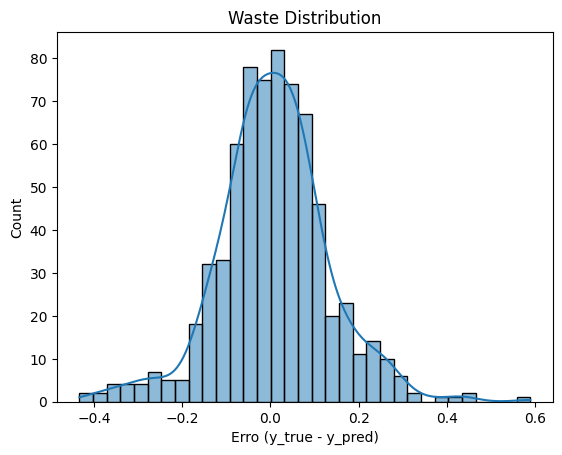

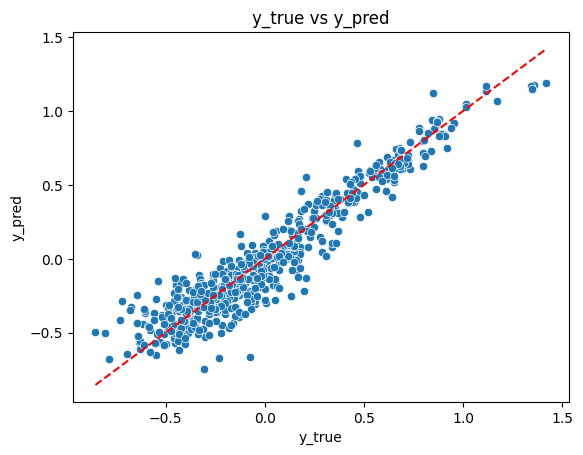

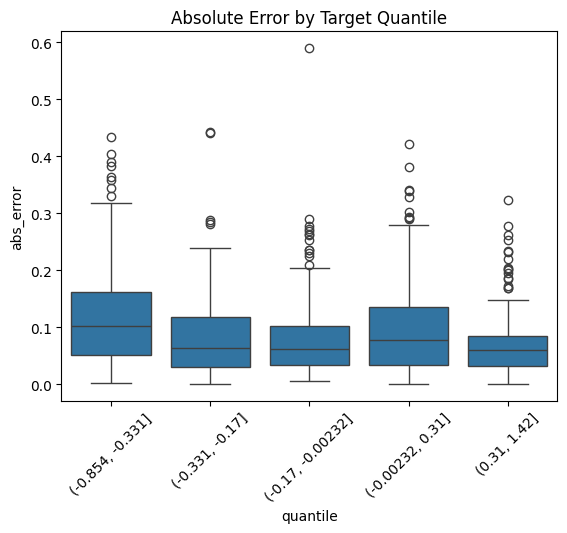

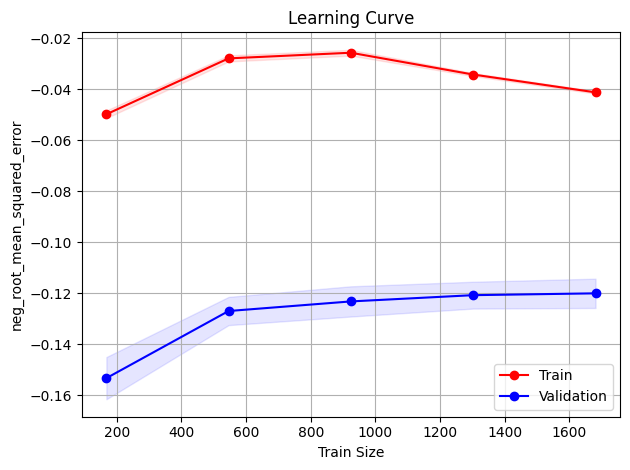

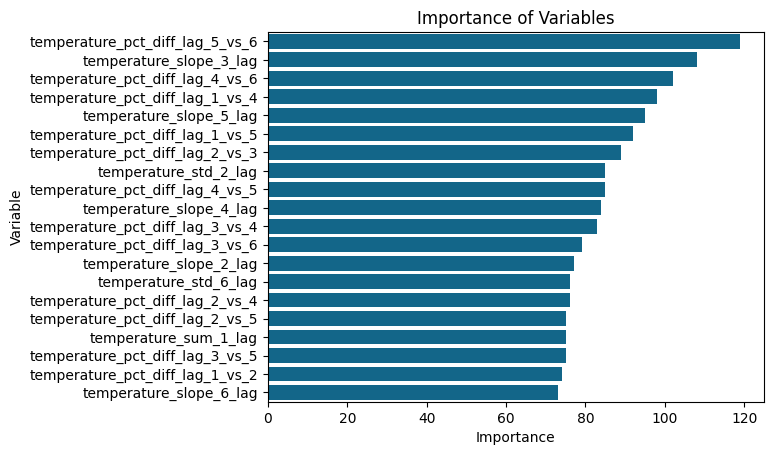

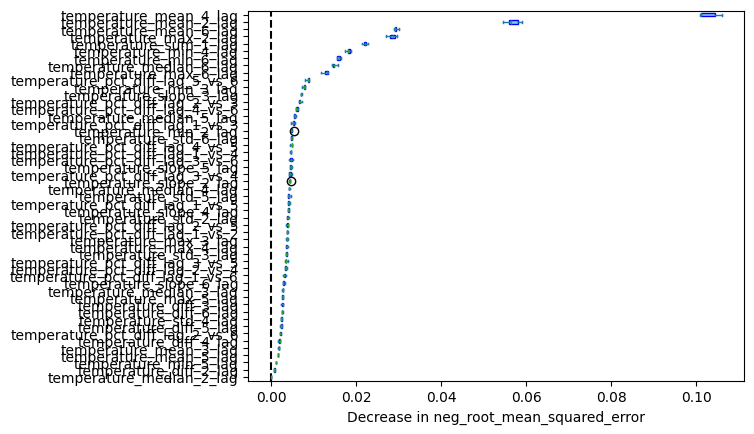

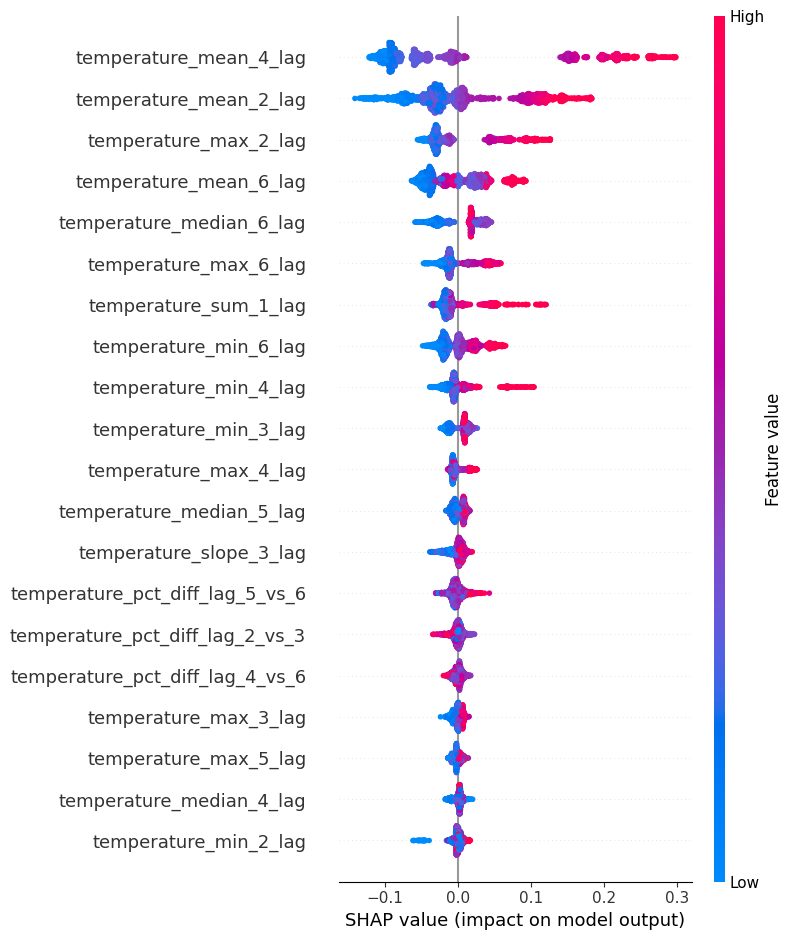

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.976873  0.047164  0.037372  6.577940e+11  0.061986   
1   Valid  0.852087  0.116399  0.085110  9.979303e-01  0.154214   
2    Test  0.836726  0.120500  0.089843  3.556388e+12  0.159686   

   Explained Variance  
0            0.976873  
1            0.852639  
2            0.836815

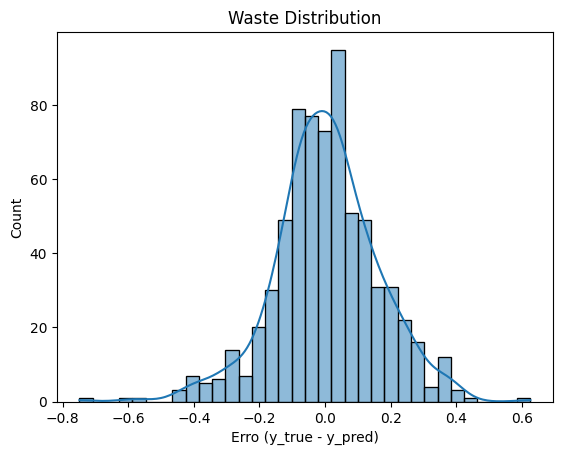

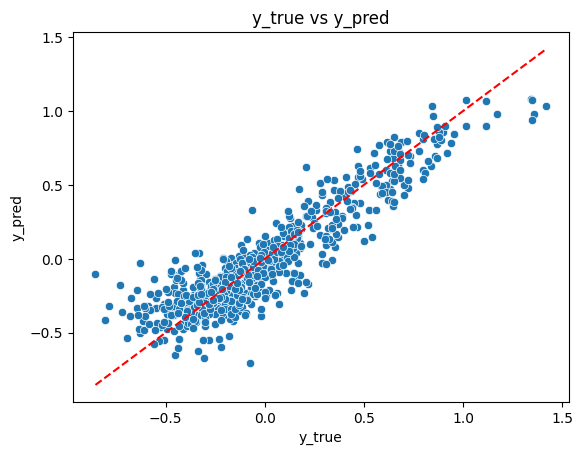

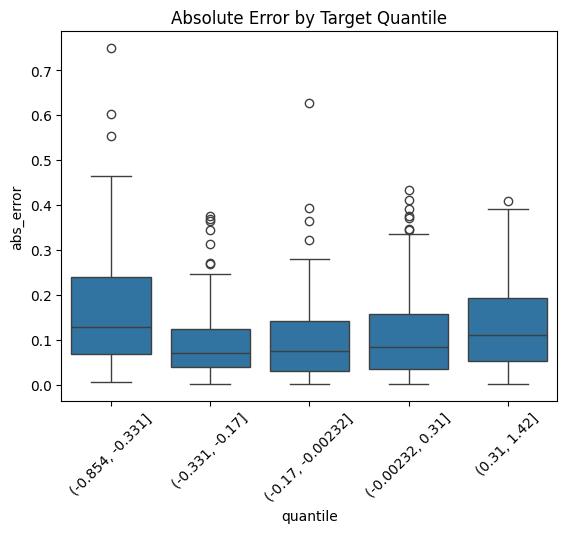

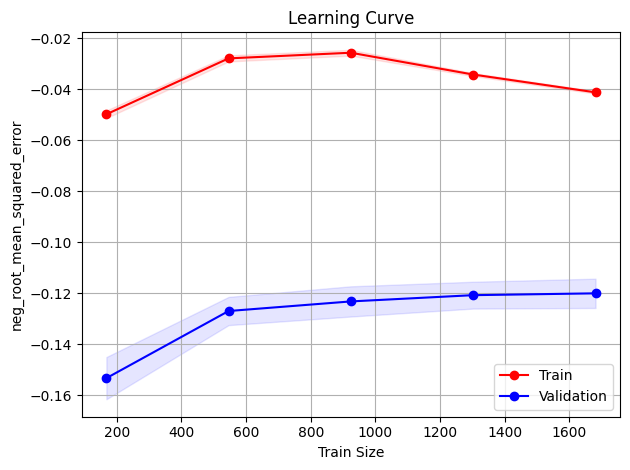

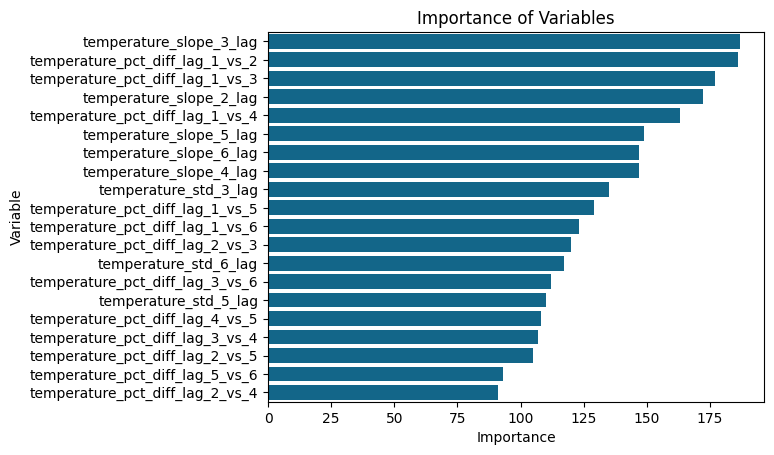

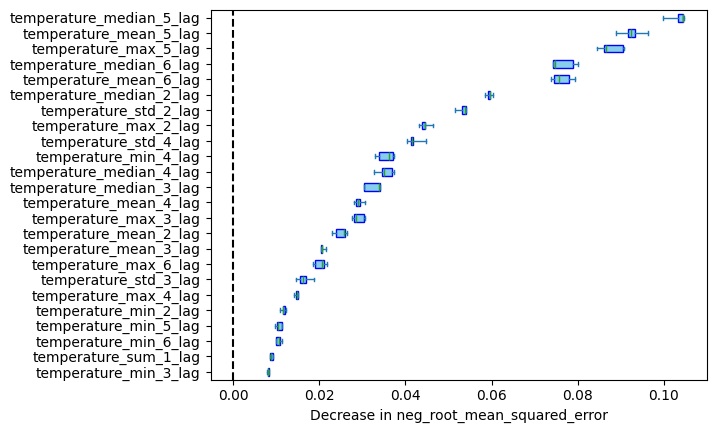

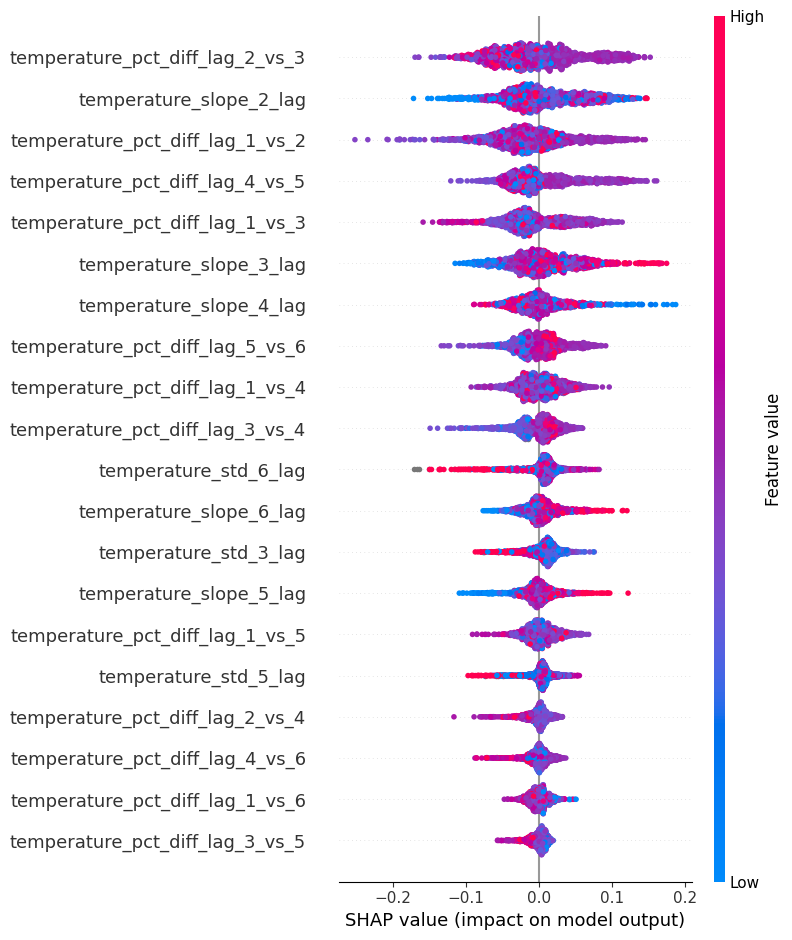

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0   Train  0.996952  0.016645  0.012714  2.553090e+11  0.022503   
1   Valid  0.862570  0.109491  0.079531  8.703045e-01  0.148649   
2    Test  0.852392  0.114382  0.086129  3.600423e+12  0.151832   

   Explained Variance  
0            0.996952  
1            0.862987  
2            0.852769

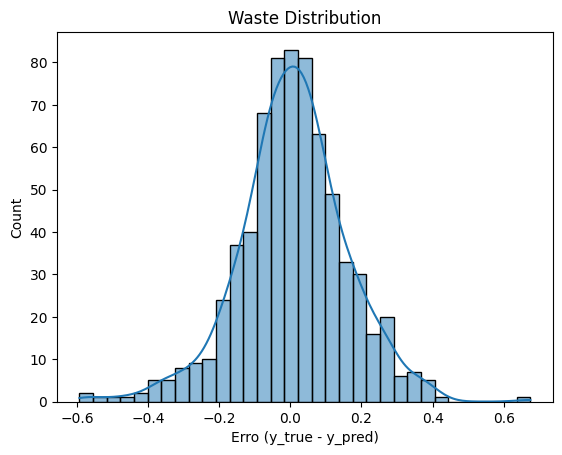

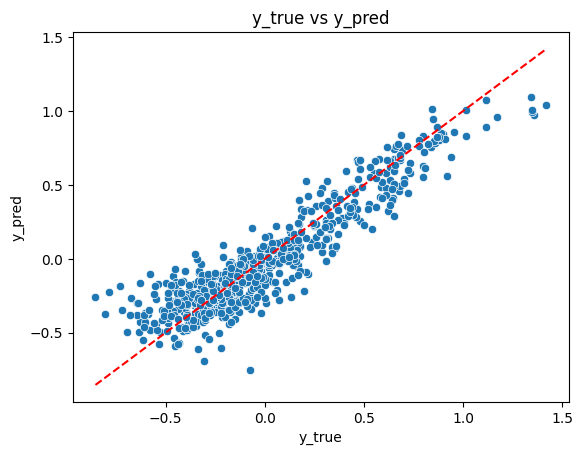

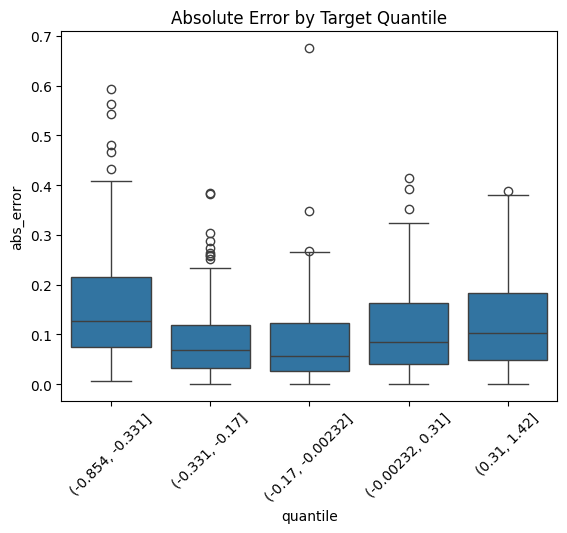

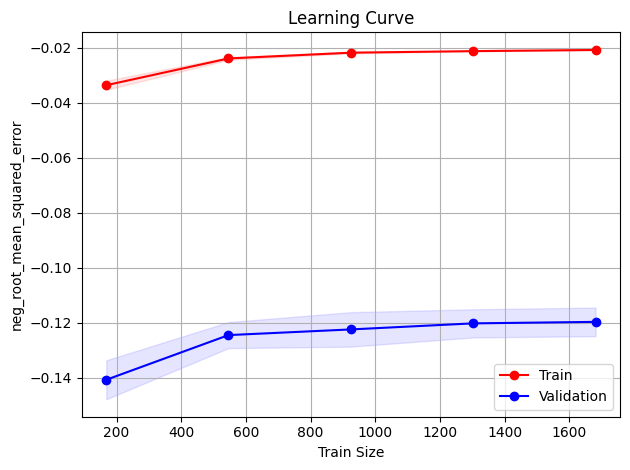

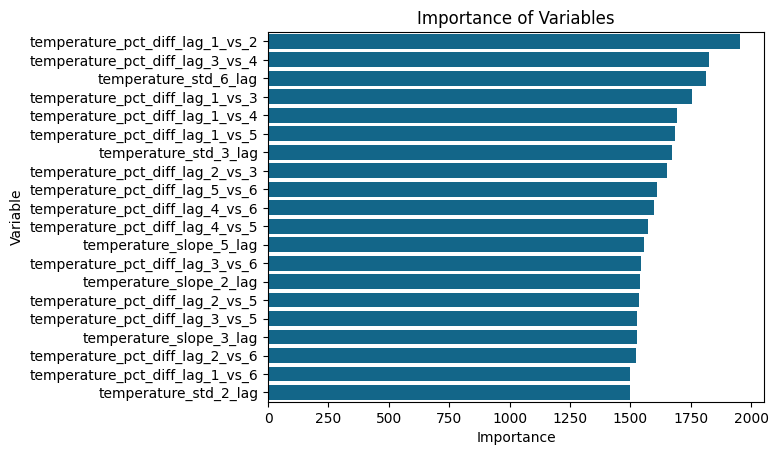

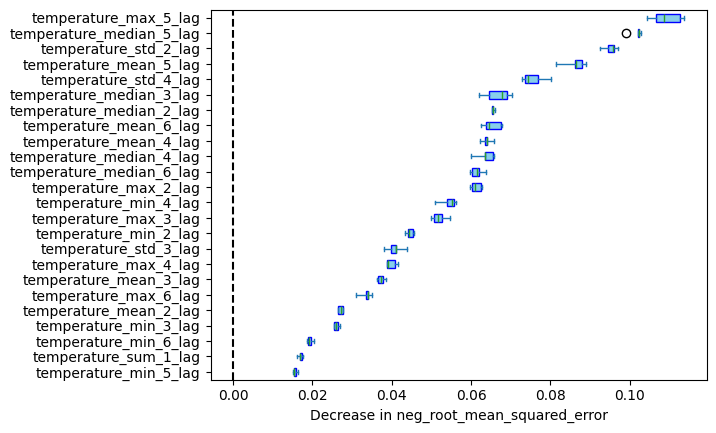

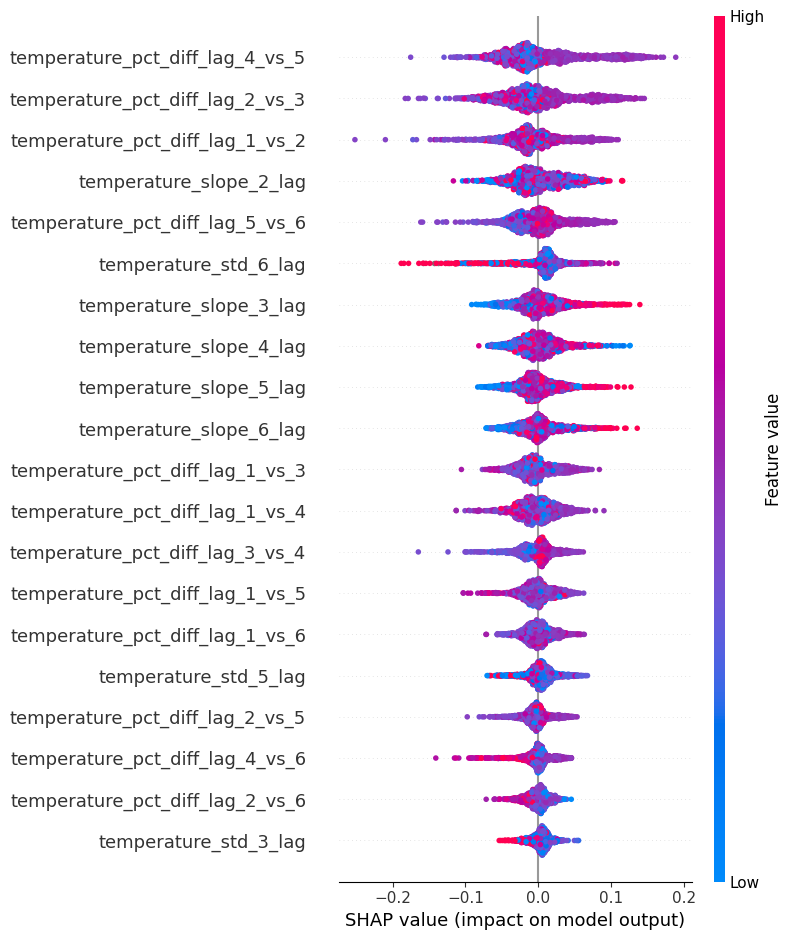

In [8]:
a.get_result_analysis()

In [9]:
acv = AutoMLLGBMRegressorCV(
    X_train, y_train, 
    X_test, y_test,
    target='temperature',
    cv=KFold(shuffle=True, random_state=42),
    best_features=best_features_reg,
    n_trials=50,
    scoring='mean_absolute_error',
    random_state=42
)

In [10]:
acv.train()

In [11]:
acv.get_metrics()

Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.913494  0.092022  0.074804  1.717605e+12  0.119694   
1      Test  0.899551  0.093196  0.068912  4.544575e+12  0.125251   
2  Train CV  0.839927  0.123473  0.097562  1.892059e+12  0.162695   
3      Test  0.836726  0.120500  0.089843  3.556388e+12  0.159686   
4  Train CV  0.848374  0.117742  0.091340  1.936211e+12  0.158172   
5      Test  0.850858  0.112663  0.083831  3.377008e+12  0.152619   

   Explained Variance               Model  
0            0.913660          Base Model  
1            0.899868          Base Model  
2            0.840492  Best Feature Model  
3            0.836815  Best Feature Model  
4            0.848899   Best Params Model  
5            0.851240   Best Params Model

base_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.913494  0.092022  0.074804  1.717605e+12  0.119694   
1      Test  0.899551  0.093196  0.068912  4.544575e+12  0.125251   

   Explained Variance  
0            0.913660  
1            0.899868

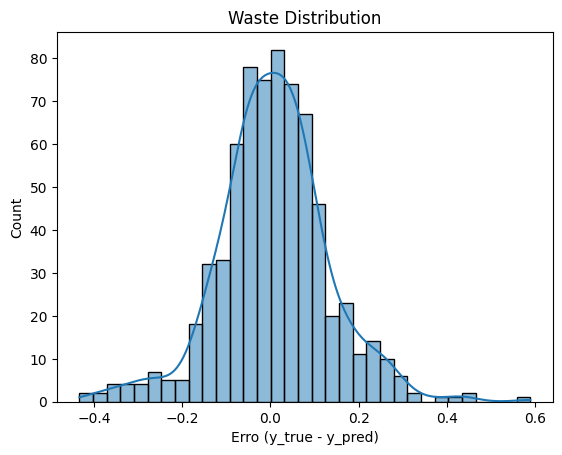

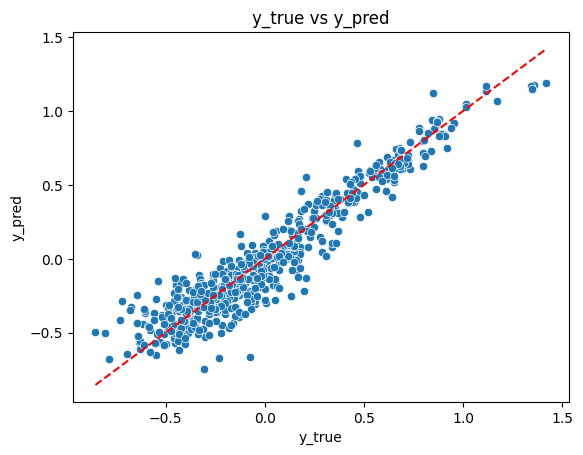

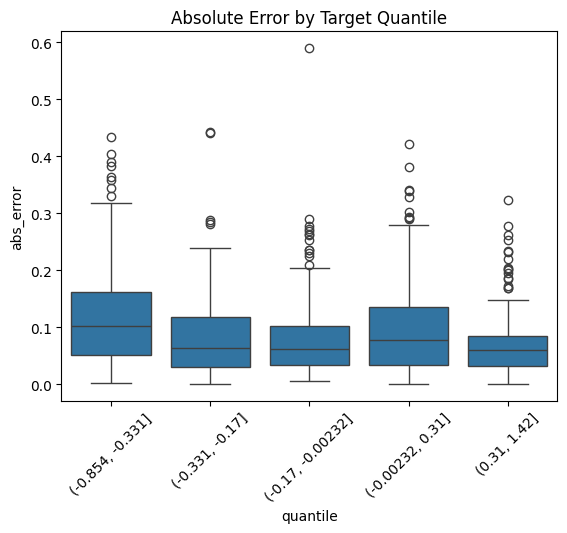

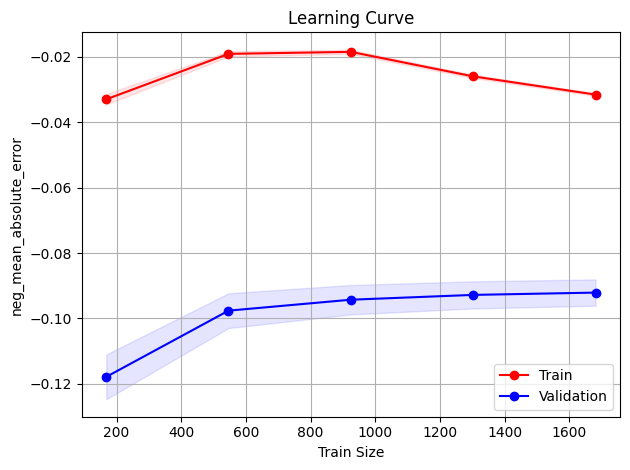

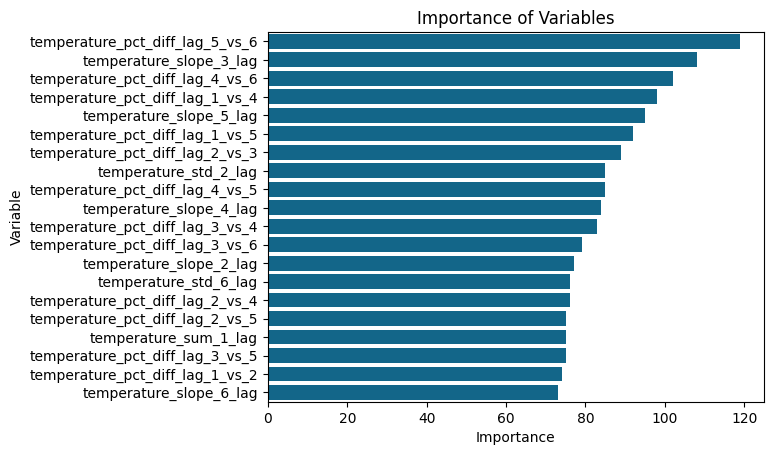

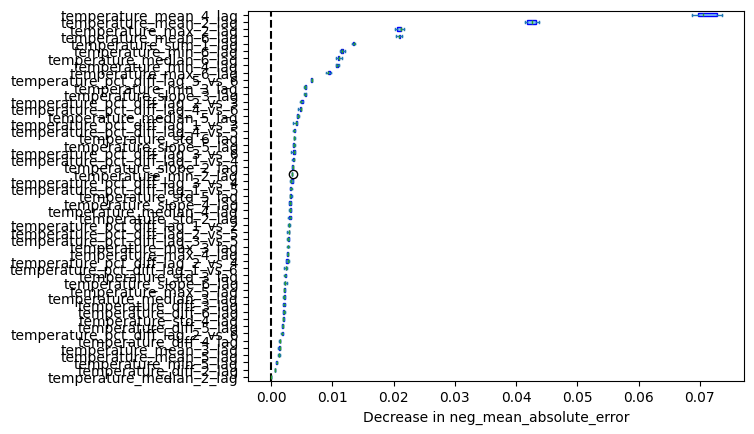

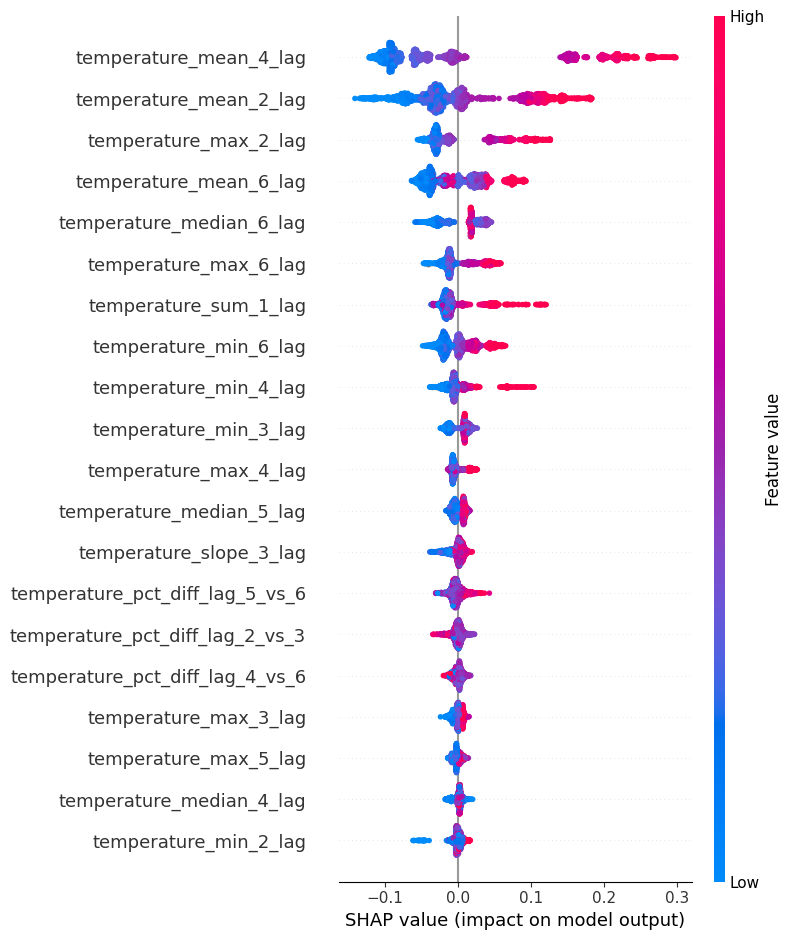

best_feature_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.839927  0.123473  0.097562  1.892059e+12  0.162695   
1      Test  0.836726  0.120500  0.089843  3.556388e+12  0.159686   

   Explained Variance  
0            0.840492  
1            0.836815

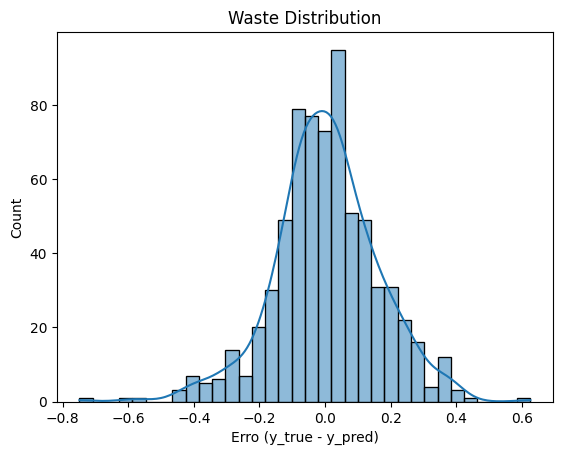

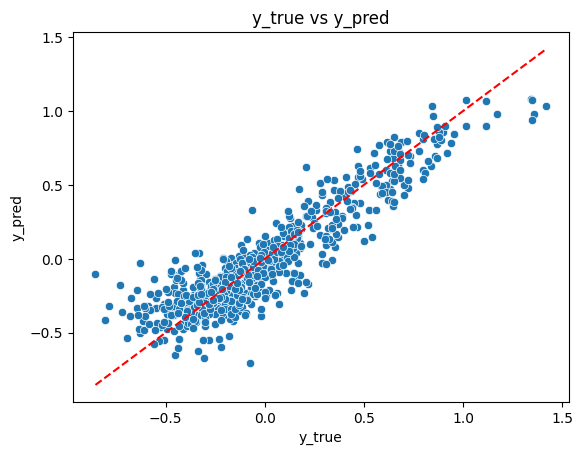

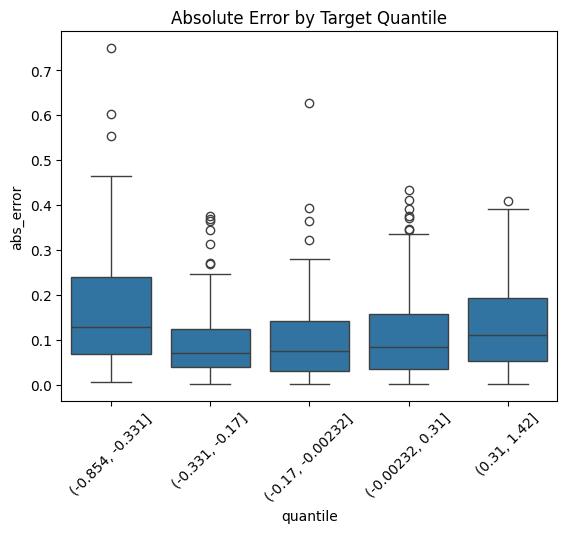

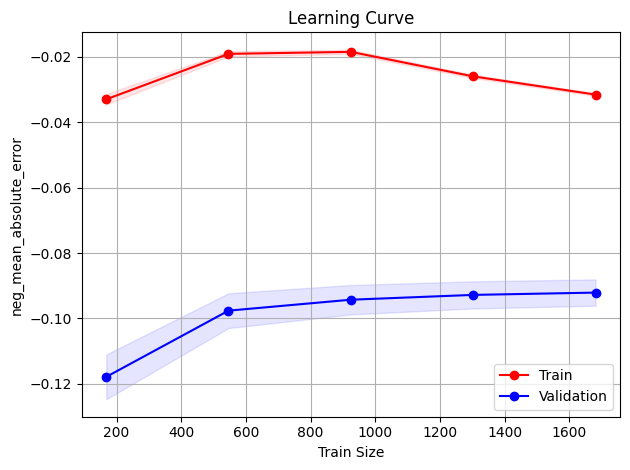

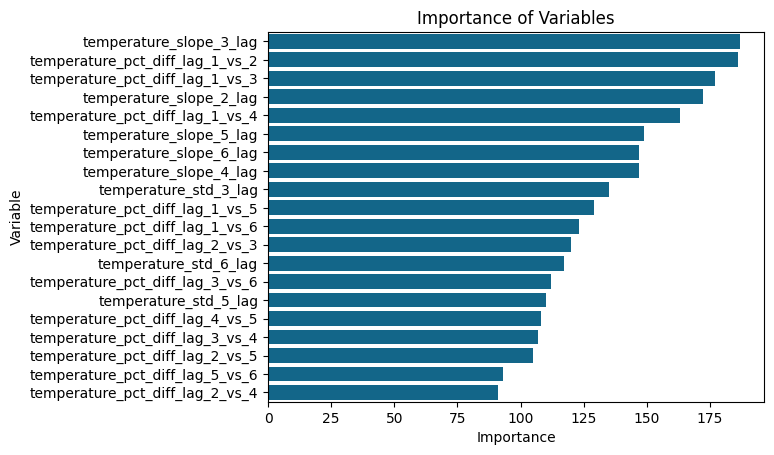

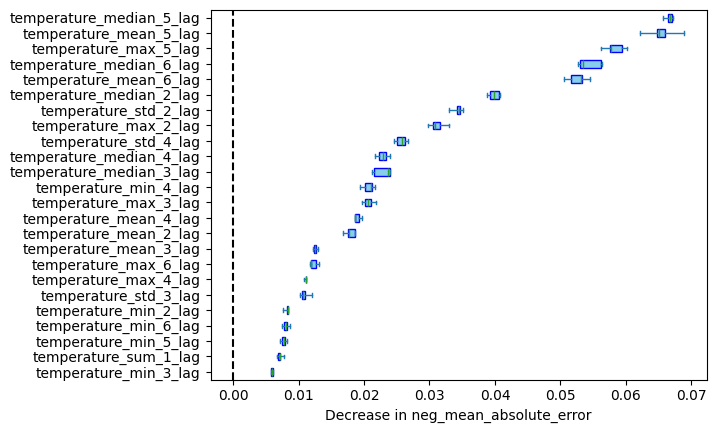

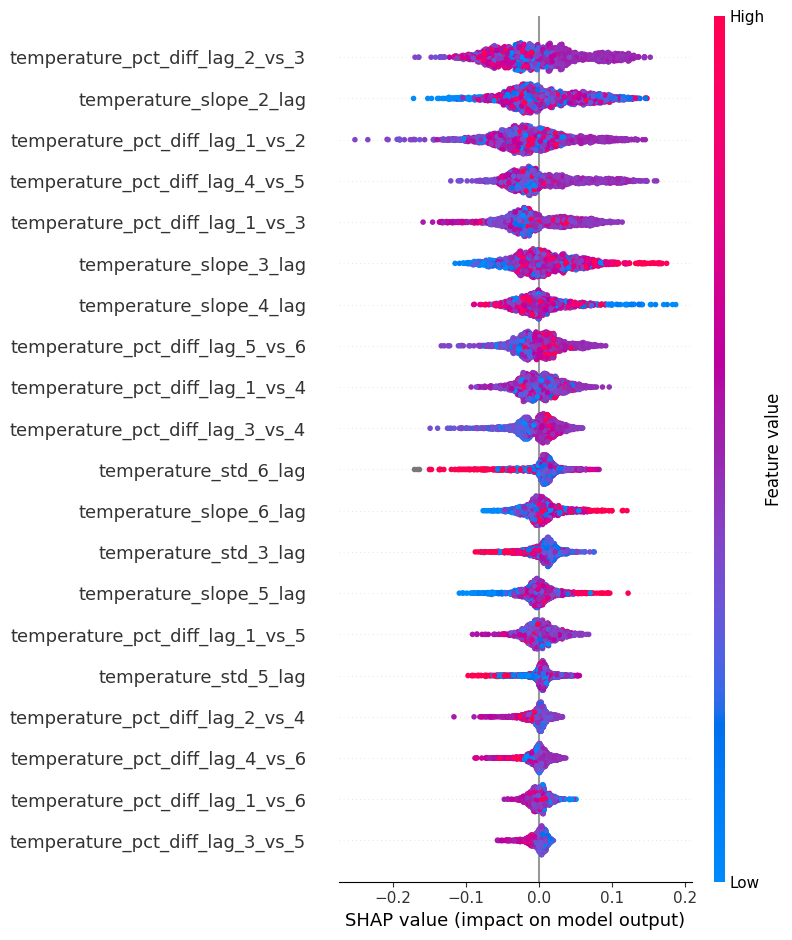

best_params_model Results


Dataset        R2       MAE     MadAE          MAPE      RMSE  \
0  Train CV  0.848374  0.117742  0.091340  1.936211e+12  0.158172   
1      Test  0.850858  0.112663  0.083831  3.377008e+12  0.152619   

   Explained Variance  
0            0.848899  
1            0.851240

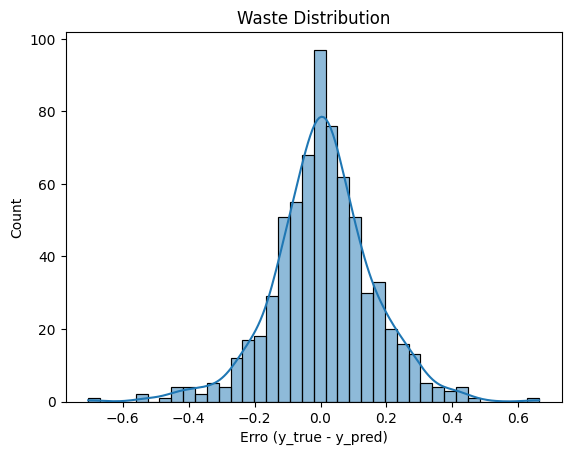

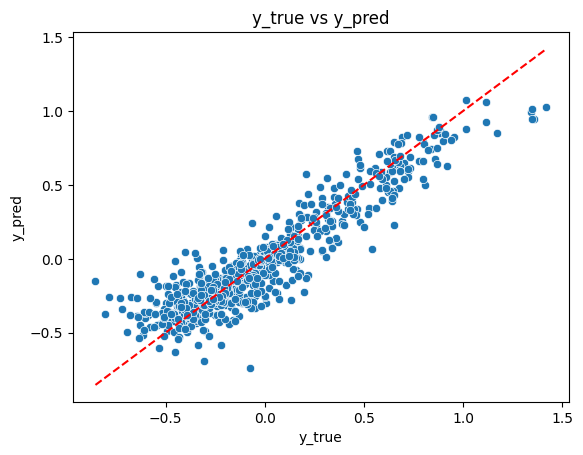

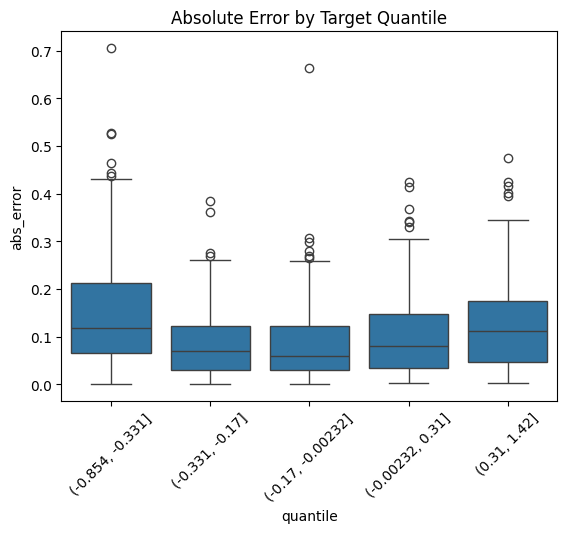

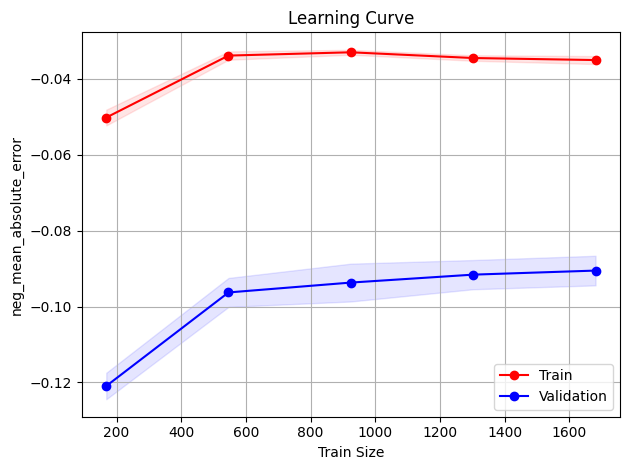

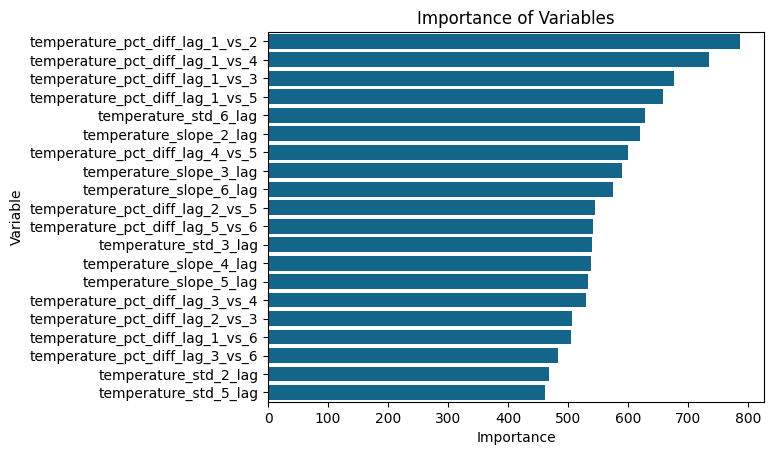

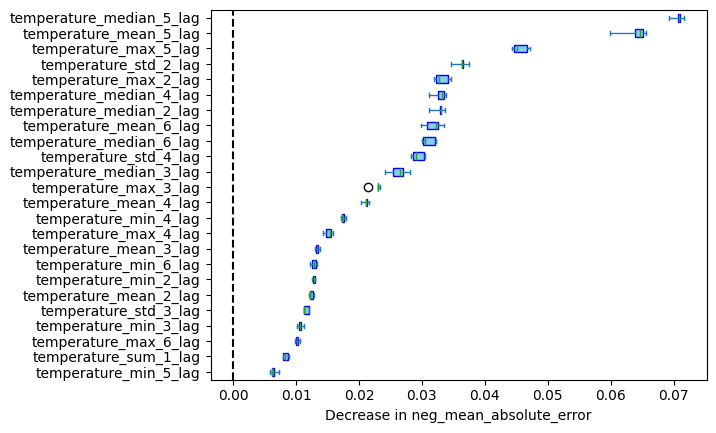

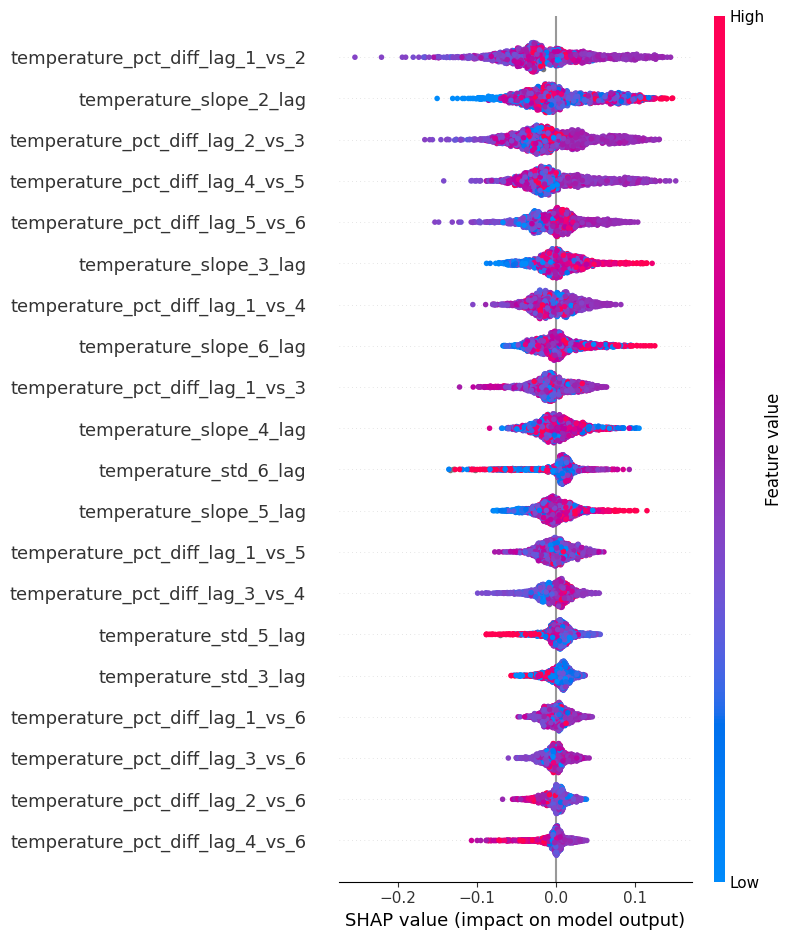

In [12]:
acv.get_result_analysis()

# Classifier

In [13]:
from dstoolkit.automl import AutoMLLGBMClassifier, AutoMLLGBMClassifierCV

In [15]:
df = pd.read_csv('../data/cs-training.csv')

X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df[['SeriousDlqin2yrs']].rename({'SeriousDlqin2yrs': 'target'}, axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y['target'])
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42, stratify=y_temp['target'])

sfm = SelectFromModel(LGBMRegressor(n_jobs=-1, random_state=42))
sfm.fit(X_train, y_train)
best_features_class = X_train.loc[:, sfm.get_support()].columns.tolist()

In [17]:
a = AutoMLLGBMClassifier(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    scoring='brier'
)

In [18]:
a.train()

In [19]:
a.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   
3   Train  0.165829           0.718093   0.279607  0.534907  0.367247   
4   Valid  0.180905           0.677816   0.266300  0.443059  0.332657   
5    Test  0.155779           0.683536   0.228194  0.484414  0.310242   
6   Train  0.165829           0.690161   0.257153  0.479555  0.334784   
7   Valid  0.160804           0.692399   0.250692  0.489609  0.331597   
8    Test  0.170854           0.675611   0.244919  0.450748  0.317384   

        AUC        KS     Brier               Model  
0  0.902256  0.644746  0.044558          Base Model  
1  0.867222  0.579020  0.048628          Base Model  
2  0.859473  0.557068  0.049605          Base Model  
3  0.852656  0.548472  0.052931  Best Feature Model  
4  0.803582  0.475138  0.055425  Best Feature Model  
5  0.796275  0.466079  0.056320  Best Feature Model  
6  0.817639  0.497915  0.055099   Best Params Model  
7  0.808165  0.483352  0.055195   Best Params Model  
8  0.798589  0.468186  0.056056   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.246231           0.740497   0.477276  0.521941  0.498611   
1   Valid  0.195980           0.732529   0.400960  0.520781  0.453083   
2    Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.902256  0.644746  0.044558  
1  0.867222  0.579020  0.048628  
2  0.859473  0.557068  0.049605

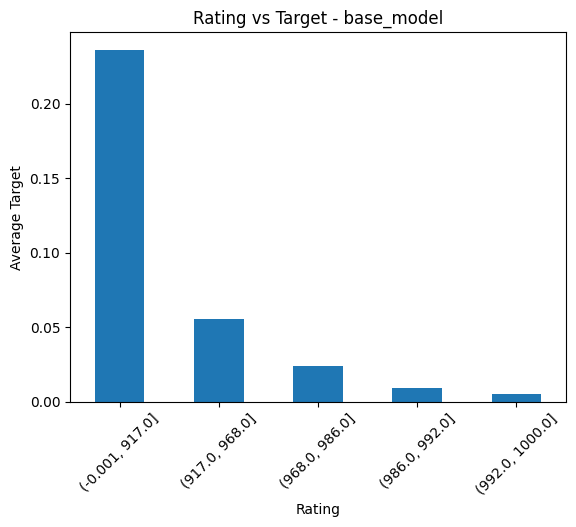

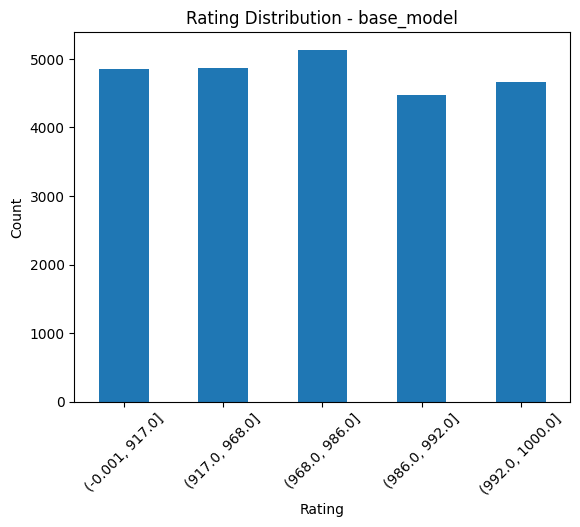

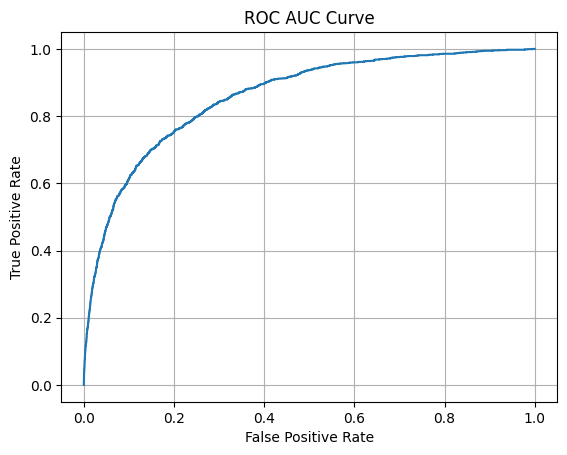

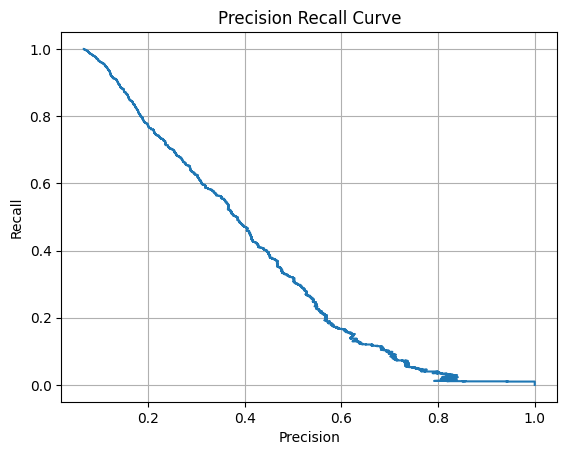

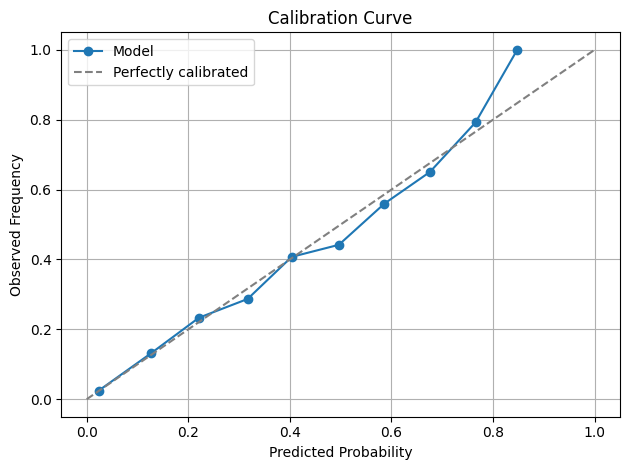

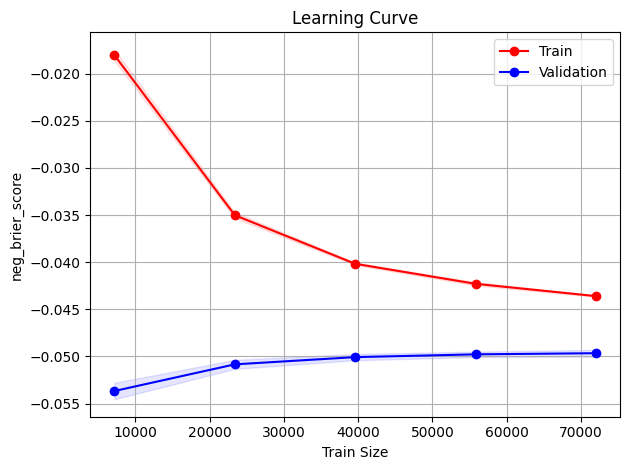

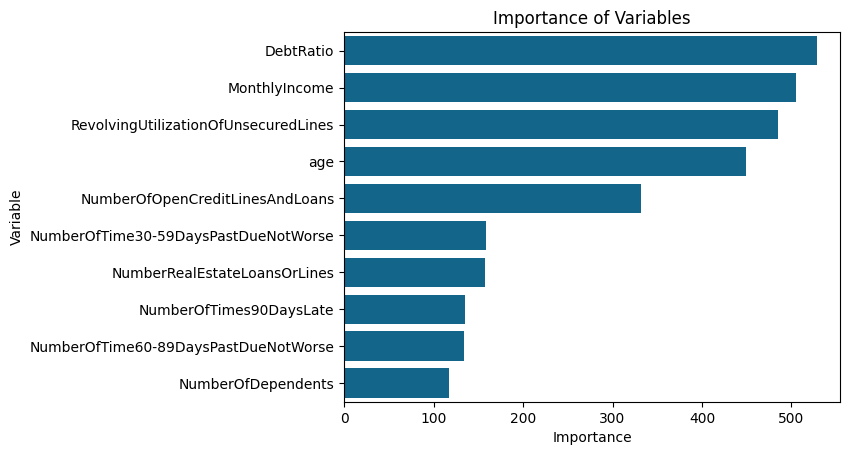

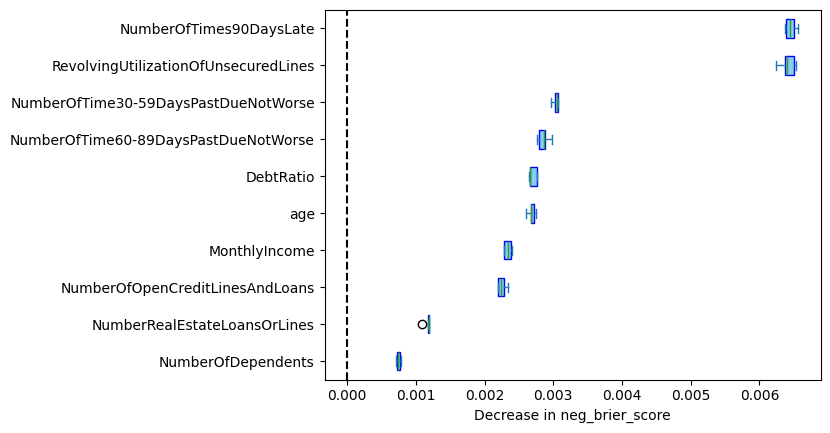

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


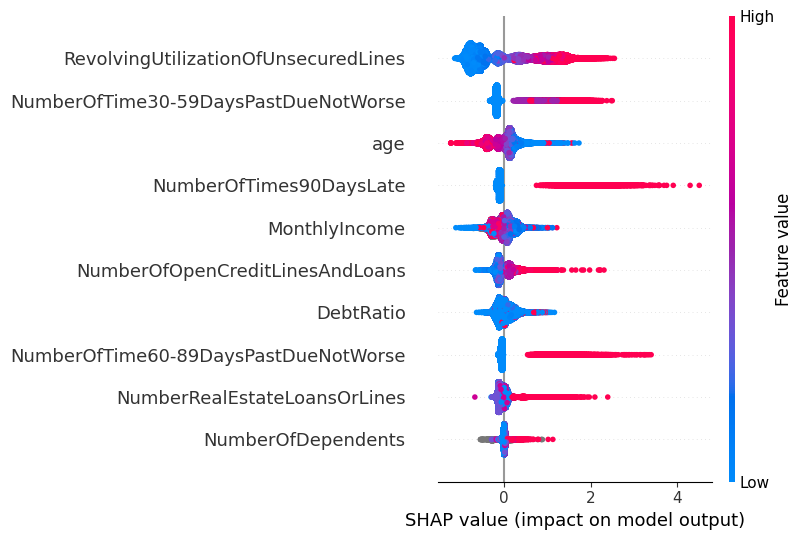

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.165829           0.718093   0.279607  0.534907  0.367247   
1   Valid  0.180905           0.677816   0.266300  0.443059  0.332657   
2    Test  0.155779           0.683536   0.228194  0.484414  0.310242   

        AUC        KS     Brier  
0  0.852656  0.548472  0.052931  
1  0.803582  0.475138  0.055425  
2  0.796275  0.466079  0.056320

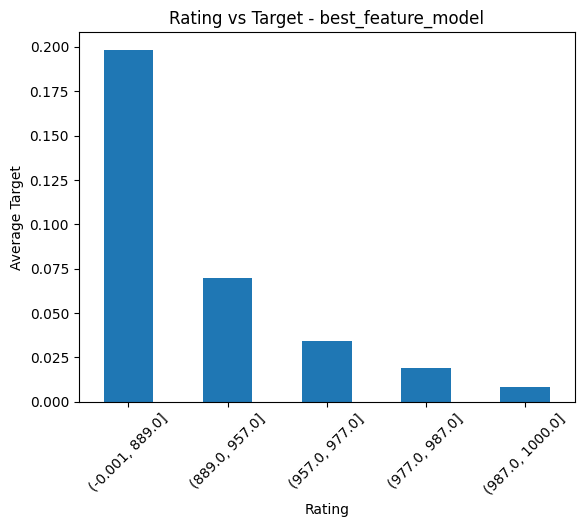

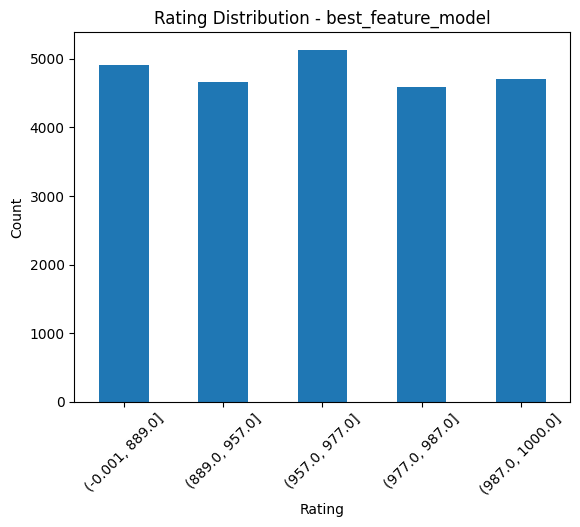

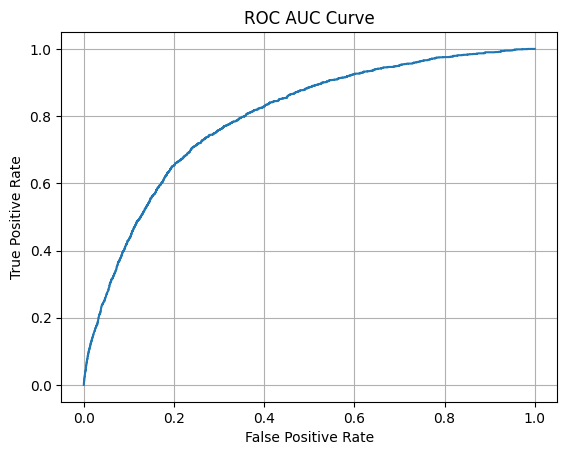

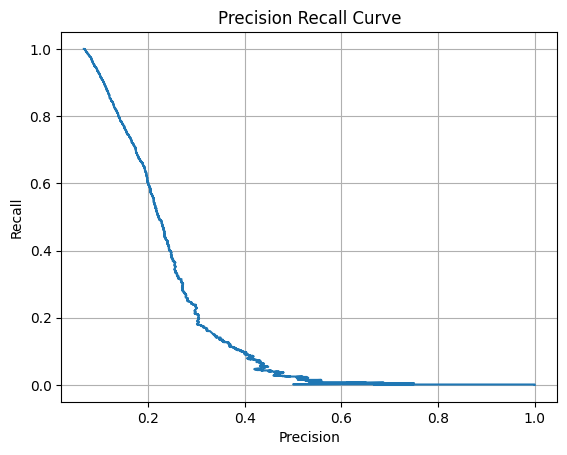

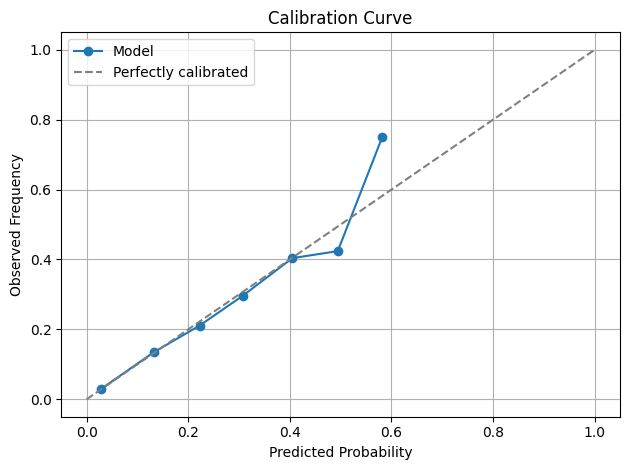

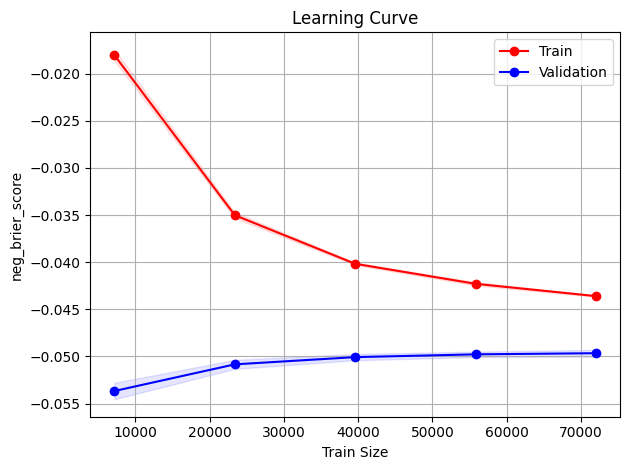

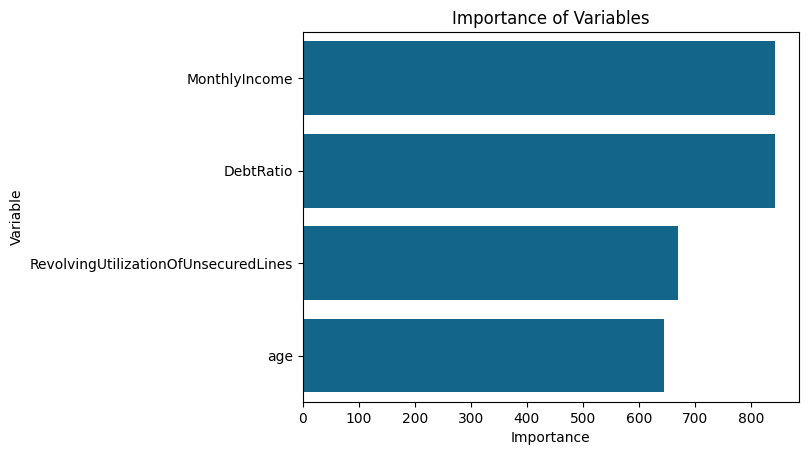

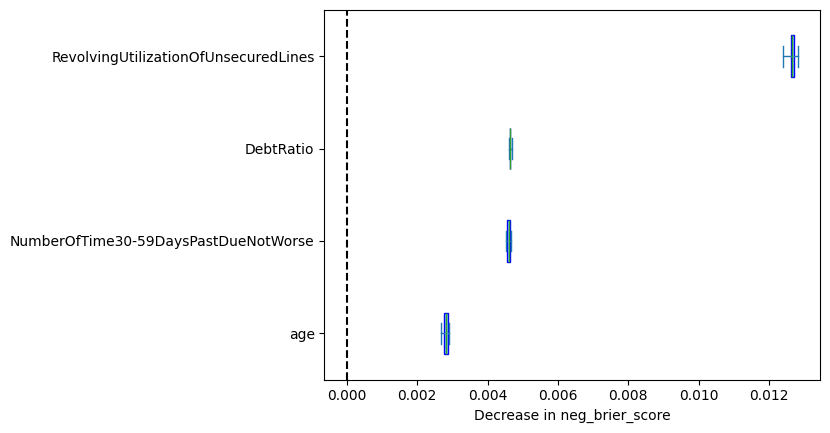

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


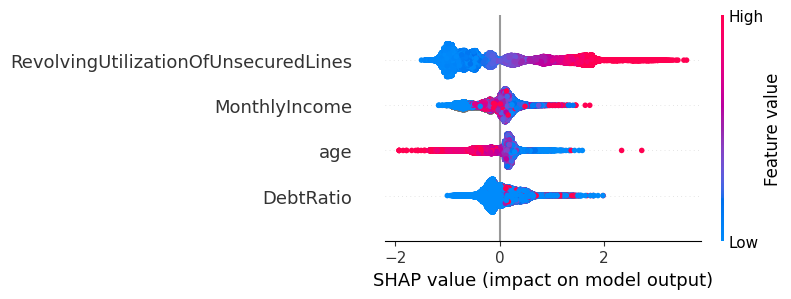

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0   Train  0.165829           0.690161   0.257153  0.479555  0.334784   
1   Valid  0.160804           0.692399   0.250692  0.489609  0.331597   
2    Test  0.170854           0.675611   0.244919  0.450748  0.317384   

        AUC        KS     Brier  
0  0.817639  0.497915  0.055099  
1  0.808165  0.483352  0.055195  
2  0.798589  0.468186  0.056056

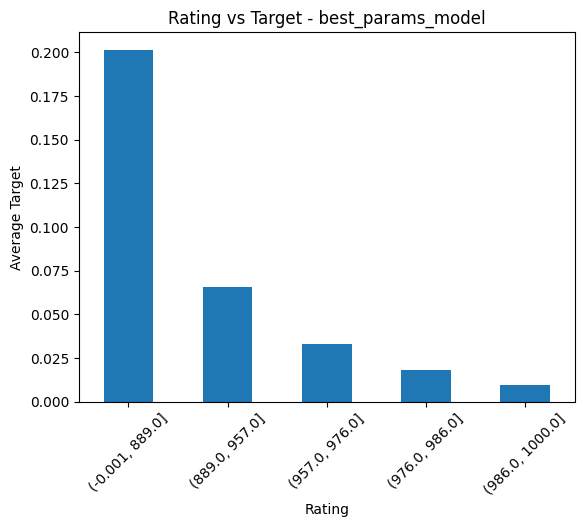

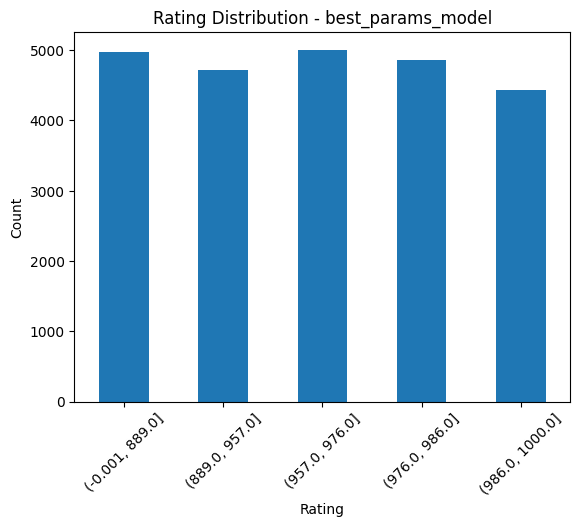

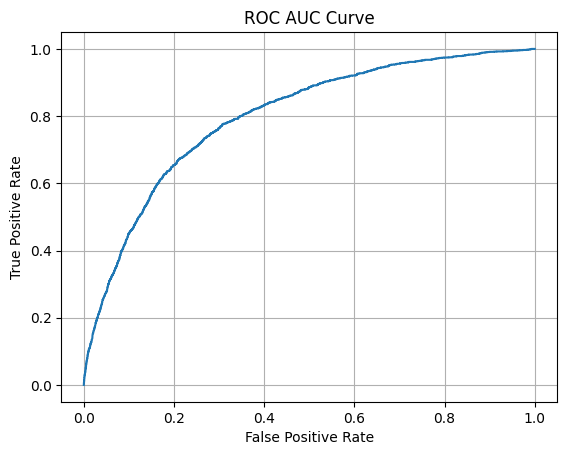

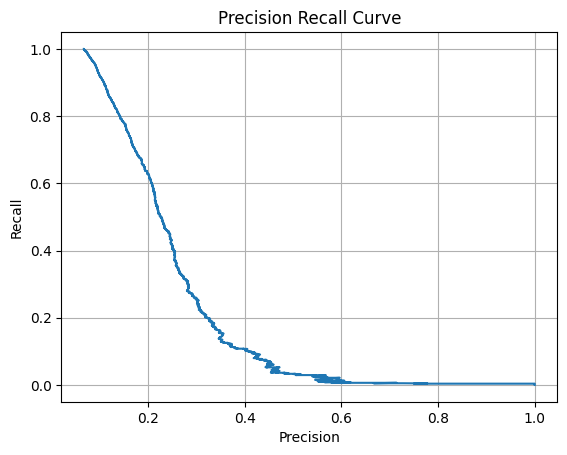

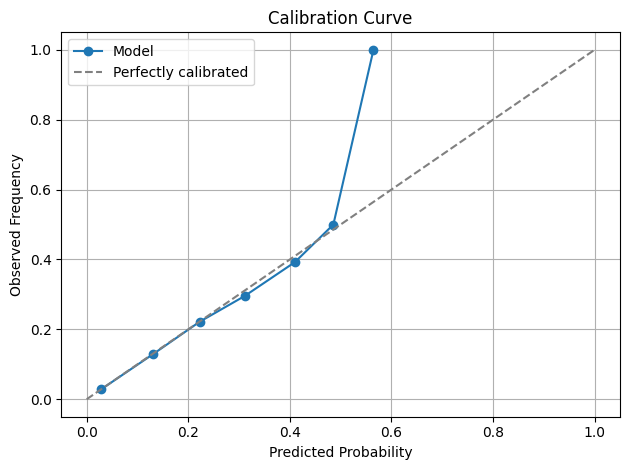

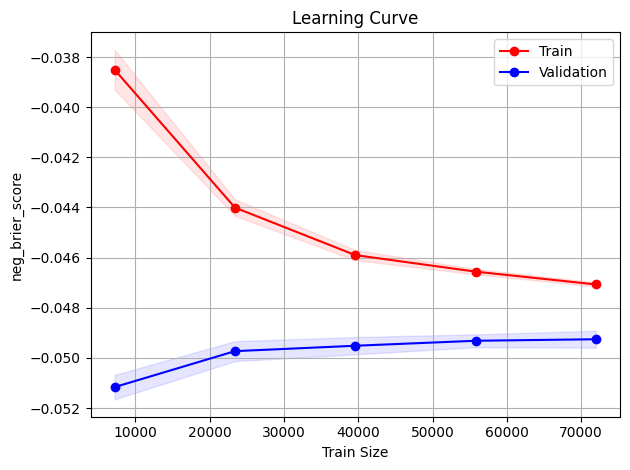

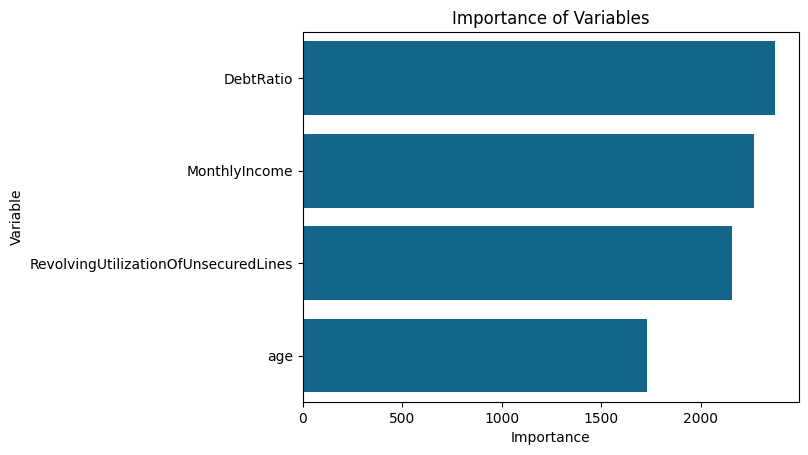

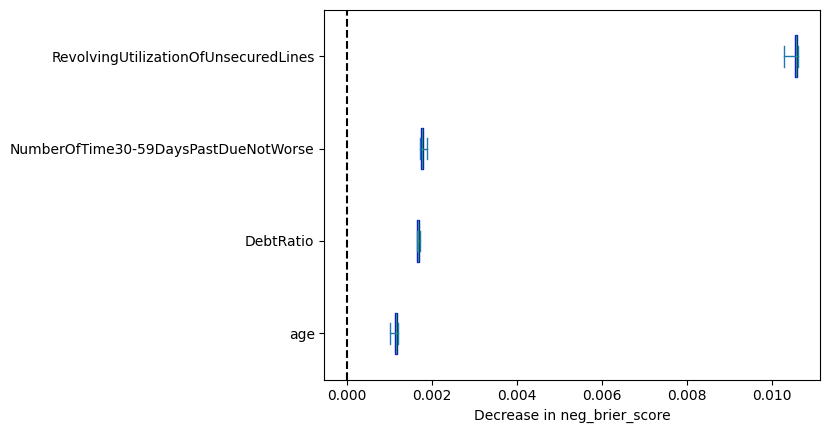

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


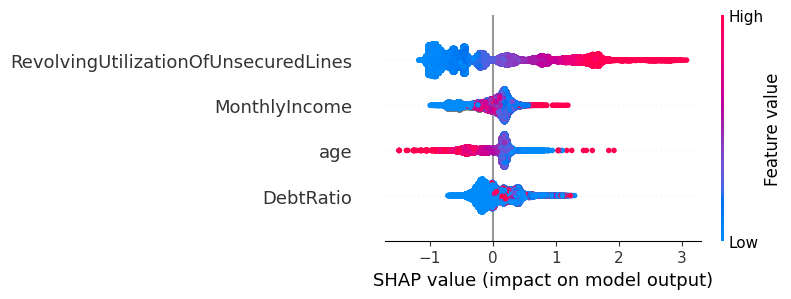

In [20]:
a.get_result_analysis()

In [21]:
acv = AutoMLLGBMClassifierCV(
    X_train, y_train, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='brier'
)

In [22]:
acv.train()

In [23]:
acv.get_metrics()

Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   
2  Train CV  0.500000           0.508137   0.490667  0.017619  0.033975   
3      Test  0.155779           0.683536   0.228194  0.484414  0.310242   
4  Train CV  0.500000           0.502392   0.559144  0.005152  0.010164   
5      Test  0.160804           0.687884   0.237273  0.488155  0.319331   

        AUC        KS     Brier               Model  
0  0.861749  0.571792  0.049660          Base Model  
1  0.859473  0.557068  0.049605          Base Model  
2  0.794171  0.465661  0.056483  Best Feature Model  
3  0.796275  0.466079  0.056320  Best Feature Model  
4  0.798772  0.473444  0.056138   Best Params Model  
5  0.799010  0.464787  0.056021   Best Params Model

base_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.586257   0.580235  0.182017  0.276759   
1      Test  0.175879           0.736884   0.363294  0.541771  0.434935   

        AUC        KS     Brier  
0  0.861749  0.571792  0.049660  
1  0.859473  0.557068  0.049605

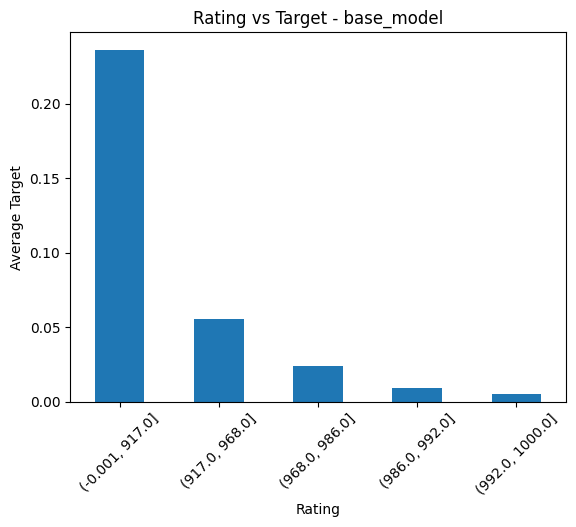

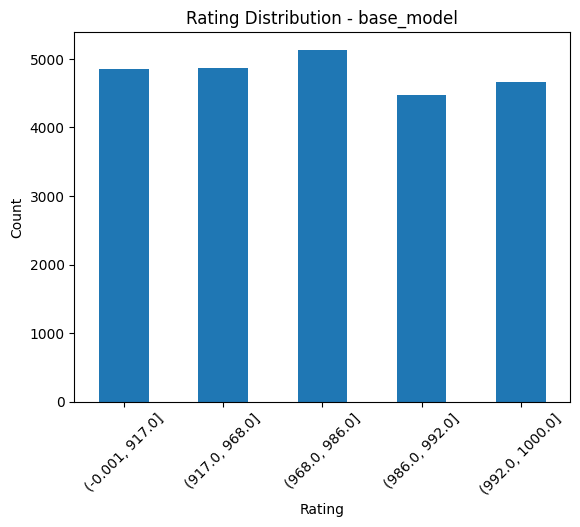

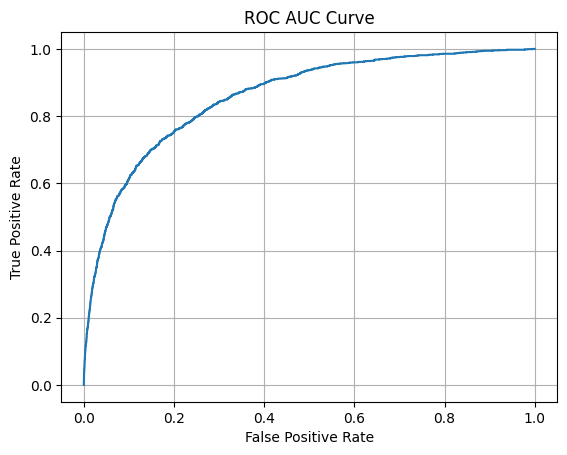

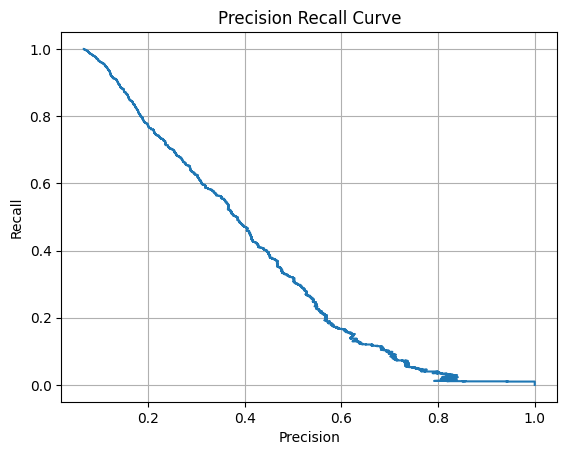

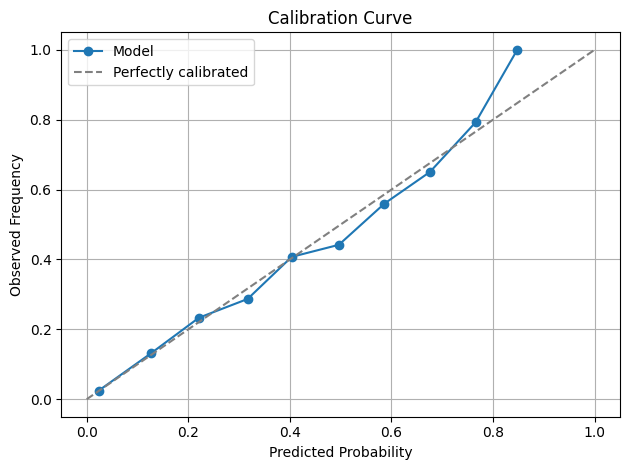

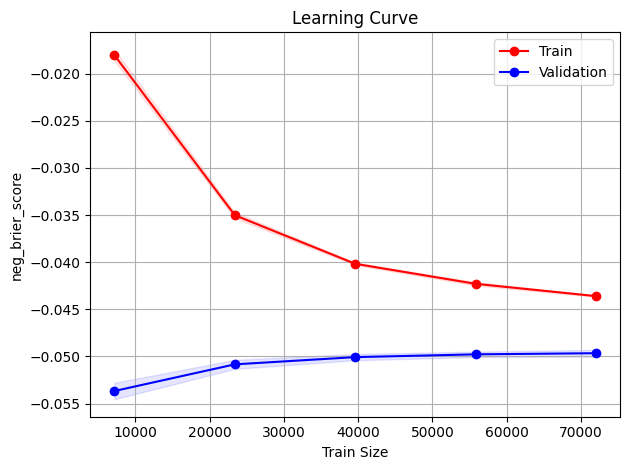

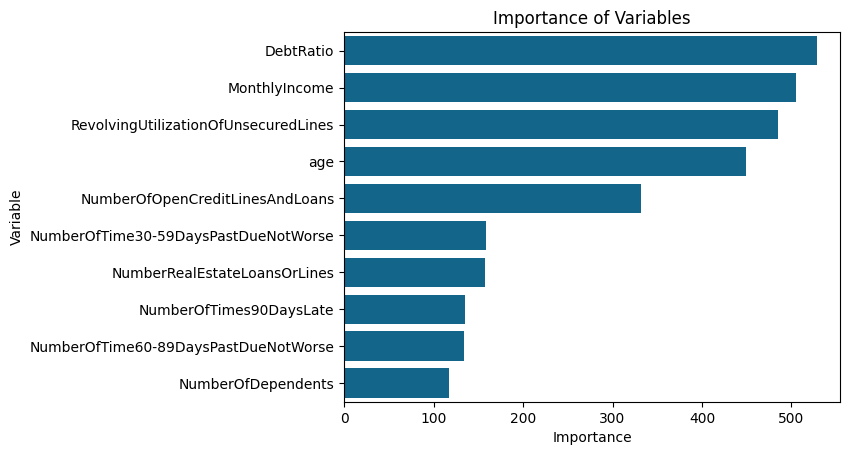

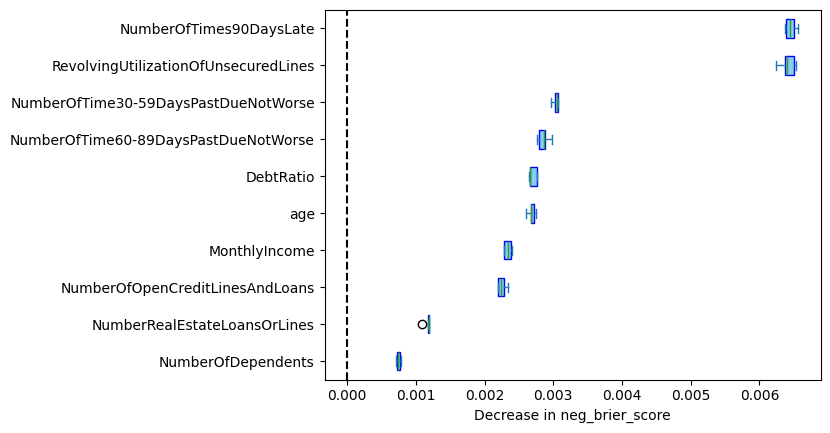

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


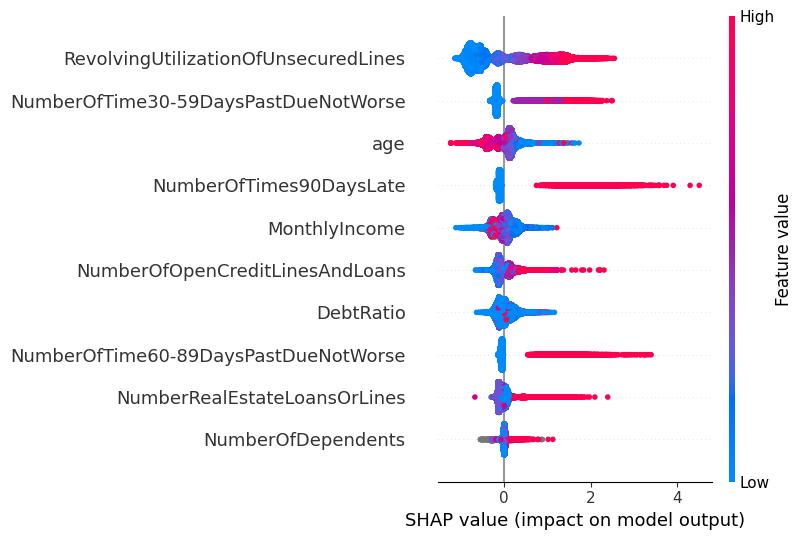

best_feature_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.508137   0.490667  0.017619  0.033975   
1      Test  0.155779           0.683536   0.228194  0.484414  0.310242   

        AUC        KS     Brier  
0  0.794171  0.465661  0.056483  
1  0.796275  0.466079  0.056320

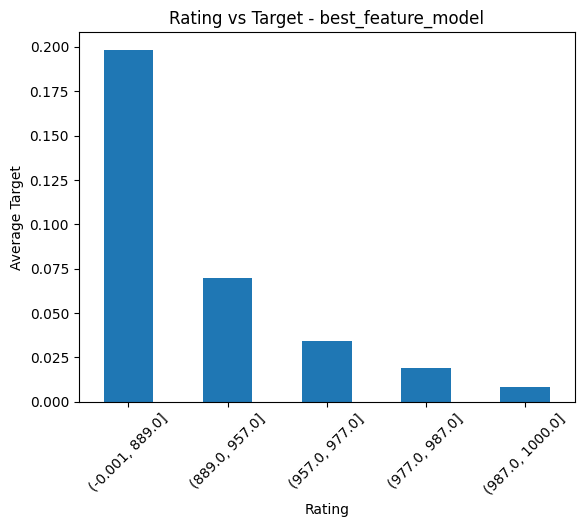

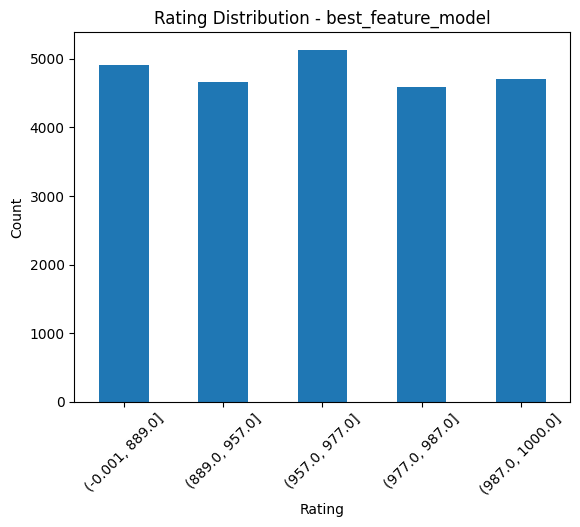

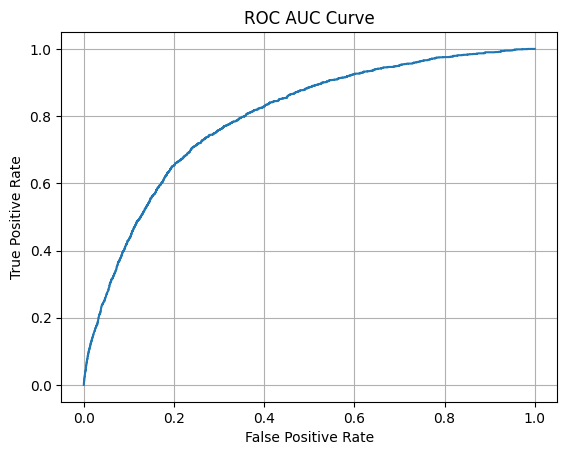

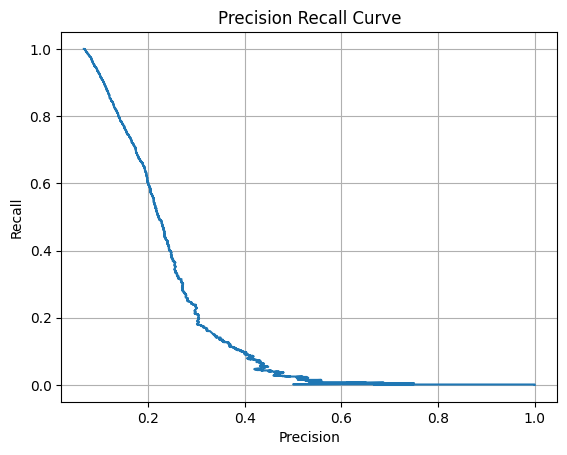

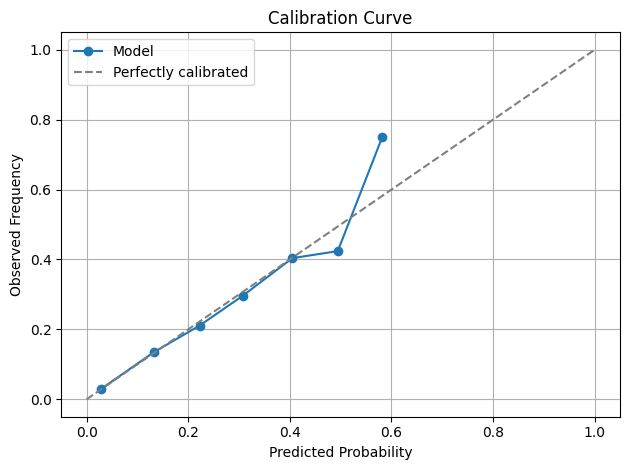

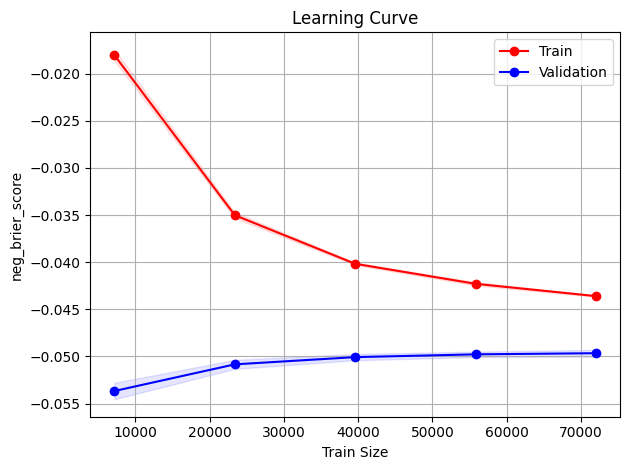

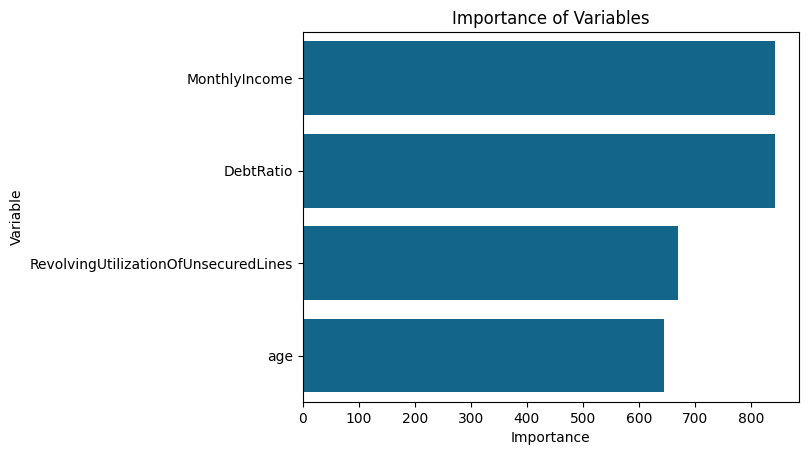

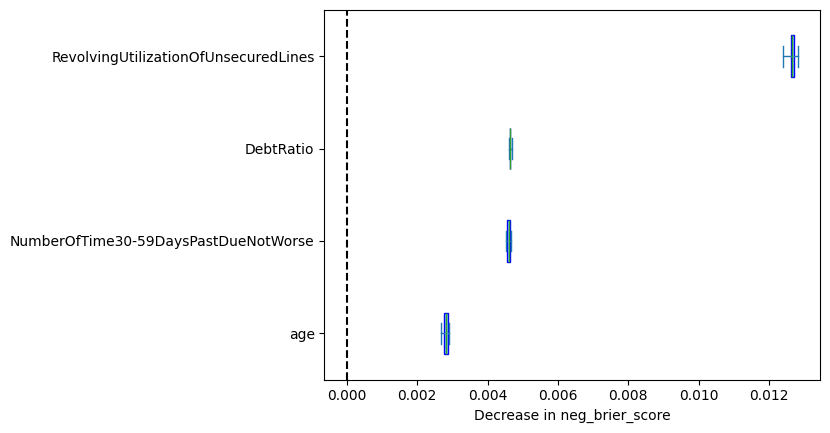

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


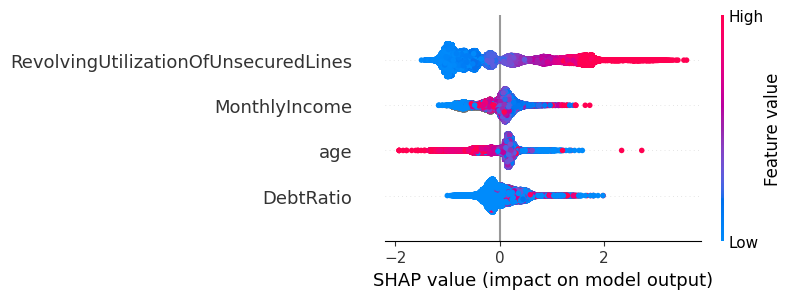

best_params_model Results


Dataset  Treshold  Balanced Accuracy  Precision    Recall        F1  \
0  Train CV  0.500000           0.502392   0.559144  0.005152  0.010164   
1      Test  0.160804           0.687884   0.237273  0.488155  0.319331   

        AUC        KS     Brier  
0  0.798772  0.473444  0.056138  
1  0.799010  0.464787  0.056021

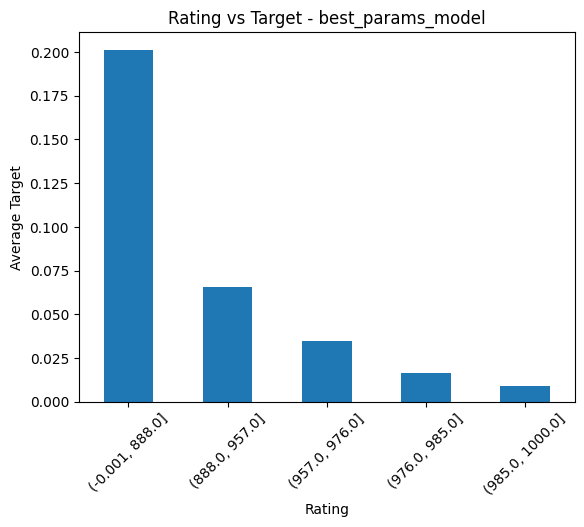

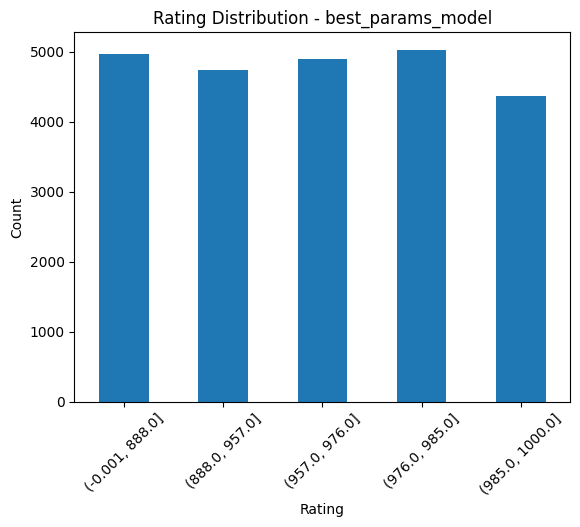

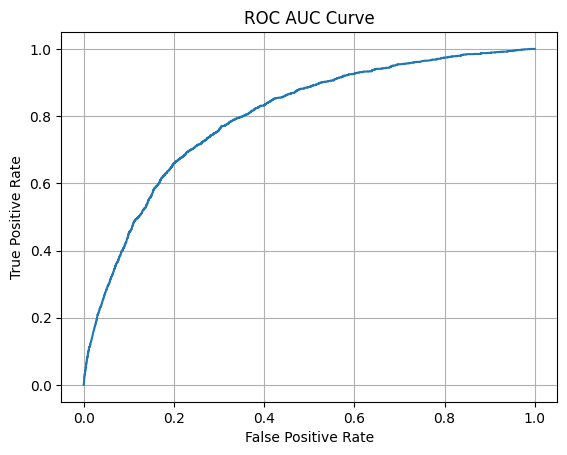

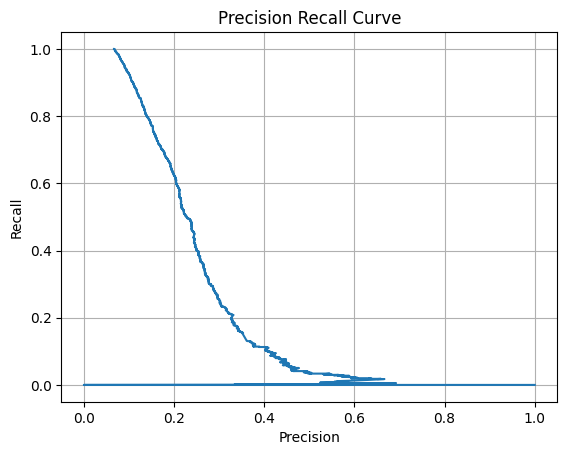

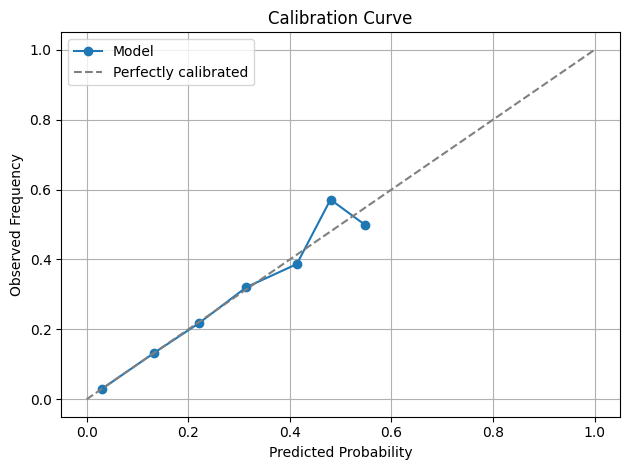

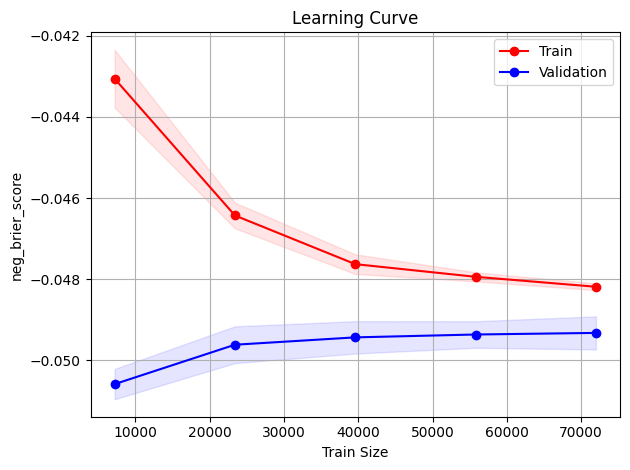

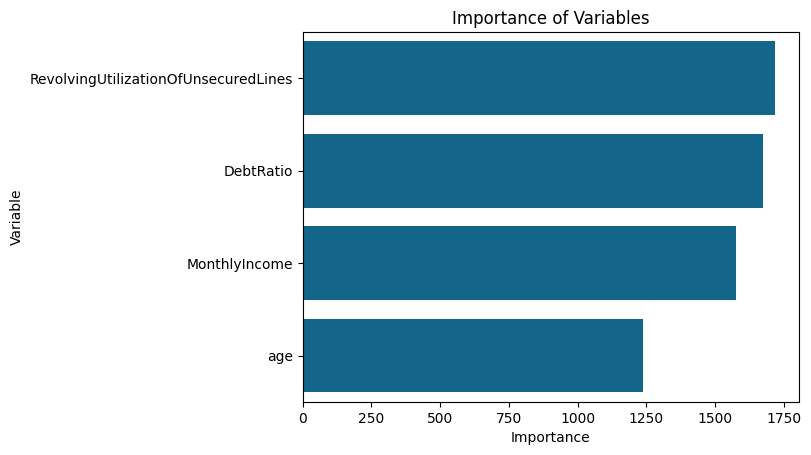

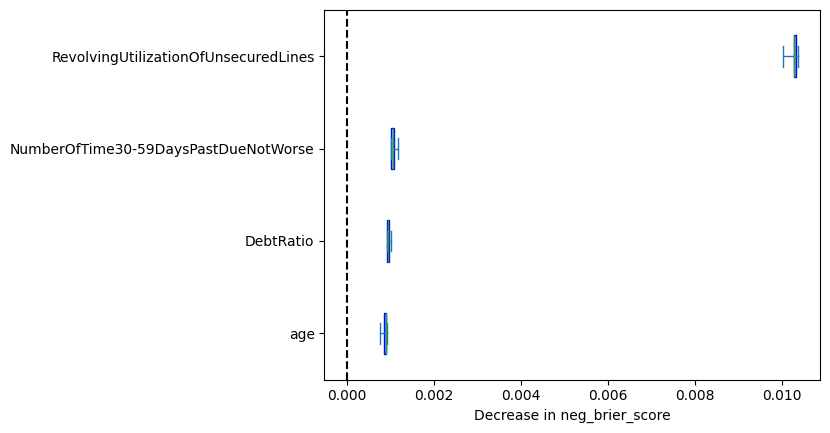

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


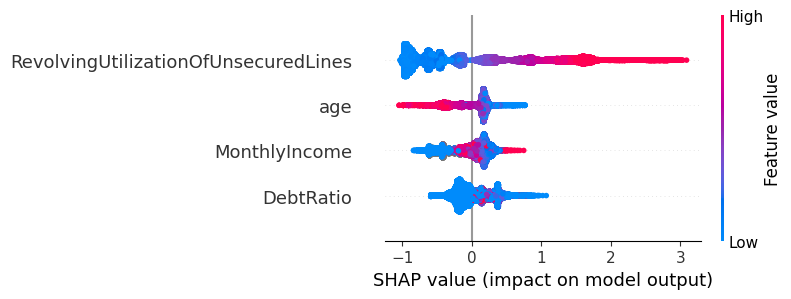

In [24]:
acv.get_result_analysis()